INSTALL NECESSARY PACKAGES

In [ ]:
pip install requests pandas
pip install requests pandas yfinance
pip install --upgrade numpy scipy pandas pmdarima
pip install --upgrade xgboost
pip install statsmodels
pip install pmdarima
pip install numpy==1.26.0 pandas==2.2.2 --force-reinstall

SyntaxError: invalid syntax (<ipython-input-1-7b74a6b188d4>, line 1)

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings("ignore")

Data Preprocessing

In [ ]:
#obtain CN GDP
import requests
import pandas as pd

# World Bank API URL for China (Country Code: CN)
WORLD_BANK_BASE_URL = "http://api.worldbank.org/v2/country/CN/indicator/"

# Indicators to Fetch
indicators = {
    "NY.GDP.MKTP.CD": "GDP (Current USD)" # GDP
}

# Parameters for API Request
params = {
    "format": "json",
    "date": "2009:2025",  # Year range
    "per_page": 1000,
}

# Fetch Data
data_frames = []
for indicator, name in indicators.items():
    response = requests.get(WORLD_BANK_BASE_URL + indicator, params=params)
    data = response.json()

    if isinstance(data, list) and "message" in data[0]:  # Check for errors
        print(f"Error fetching data for {name}: {data[0]['message']}")
        continue

    # Convert JSON to DataFrame
    df = pd.DataFrame.from_records(data[1])
    df = df[["date", "value"]]
    df.columns = ["Year", name]
    df["Year"] = df["Year"].astype(int)
    data_frames.append(df)

# Merge all indicators into one DataFrame
china_macro_data = data_frames[0]
for df in data_frames[1:]:
    china_macro_data = china_macro_data.merge(df, on="Year", how="outer")

# Display first few rows
print(china_macro_data.head())

# Save to CSV for further analysis
china_macro_data.to_csv("china_gdp_data.csv", index=False)
print("Data saved as 'china_gdp_data.csv'.")


   Year  GDP (Current USD)
0  2023       1.779478e+13
1  2022       1.788178e+13
2  2021       1.782046e+13
3  2020       1.468774e+13
4  2019       1.427997e+13
Data saved as 'china_gdp_data.csv'.


In [ ]:
#OBTAIN CN INFLATION RATE
import pandas as pd

# Load the dataset (Replace 'your_file.csv' with the actual file path)
df = pd.read_csv('CHNCPIALLMINMEI.csv')

# Convert date column to datetime format
df['observation_date'] = pd.to_datetime(df['observation_date'])

# Sort values by date (in case they are unordered)
df = df.sort_values(by='observation_date')

# Compute Month-over-Month (MoM) inflation rate
df['MoM_Inflation'] = df['CHNCPIALLMINMEI'].pct_change() * 100
df.to_csv("inflation_cn.csv", index=False)


In [ ]:
#COMBINE INFLATION WITH GDP FOR CN
inflation_df = pd.read_csv("inflation_cn.csv")
inflation_df['observation_date'] = pd.to_datetime(inflation_df['observation_date'], format='%d/%m/%y')
inflation_df['YearMonth'] = inflation_df['observation_date'].dt.strftime('%Y-%m')  # Convert to YYYY-MM format


gdp_df = pd.read_csv("china_gdp_data.csv")
gdp_df['Year'] = gdp_df['Year'].astype(str)

expanded_gdp = pd.DataFrame({
    "YearMonth": [f"{year}-{month:02d}" for year in gdp_df['Year'] for month in range(1, 13)],
    "GDP (Current USD)": sum([[gdp_df.loc[gdp_df['Year'] == year, 'GDP (Current USD)'].values[0]] * 12 for year in gdp_df['Year']], [])
})
final_df = pd.merge(inflation_df, expanded_gdp, on="YearMonth", how="inner")
import pandas as pd

# Drop 'observation_date' column
final_df = final_df.drop(columns=['observation_date'])

# Function to expand each month into daily data
expanded_data = []

for _, row in final_df.iterrows():
    # Generate all days in the given month
    all_days = pd.date_range(start=f"{row['YearMonth']}-01", periods=pd.Period(row['YearMonth']).days_in_month, freq='D')

    # Create new rows for each day with the same values for 'MoM_Inflation' and 'GDP (Current USD)'
    for day in all_days:
        expanded_data.append({'date': day.strftime('%Y-%m-%d'), 'MoM_Inflation': row['MoM_Inflation'], 'GDP (Current USD)': row['GDP (Current USD)']})

# Convert expanded data into a DataFrame
daily_df = pd.DataFrame(expanded_data)
daily_df.to_csv("daily_inflation_gdp_cn.csv", index=False)


In [ ]:
#Obtain Important currency pairs
import yfinance as yf
import pandas as pd

# Define the currency pairs
currency_pairs = {
    "EUR/CNY": "EURCNY=X",
    "USD/EUR": "EURUSD=X"
}

# Define the date range
start_date = "2009-01-01"
end_date = "2024-12-31"

# Create an empty DataFrame
exchange_rates = pd.DataFrame()

# Fetch the data
for pair, ticker in currency_pairs.items():
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        exchange_rates[pair] = df['Close']  # Store only closing prices

# Ensure data is not empty
if exchange_rates.empty:
    print("No data was retrieved. Please check the tickers and date range.")
else:
    # Save to CSV
    exchange_rates.to_csv("exchange_rates.csv")
    print(exchange_rates.head())  # Display the first few rows


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

            EUR/CNY   USD/EUR
Date                         
2009-01-01   9.5852  1.399894
2009-01-02   9.4760  1.392292
2009-01-05   9.2572  1.364592
2009-01-06   9.1717  1.351004
2009-01-07   9.3498  1.361100


In [ ]:
# US MACRO DATA FROM FRED_API
import requests
import pandas as pd

# Replace with your FRED API Key
FRED_API_KEY = "0d9ce6210e20d9b2992b8a08a2280290"

# Define US macroeconomic indicators from FRED
us_macro_indicators = {
    "GDP": "US GDP (Billion USD)",  # US GDP
    "CPIAUCSL": "Inflation (CPI)",  # Consumer Price Index (CPI)
    "FEDFUNDS": "Federal Funds Rate",  # US Interest Rate
    "UNRATE": "Unemployment Rate",  # US Unemployment Rate
    "DTWEXBGS": "US Dollar Index",  # Trade Weighted US Dollar Index
    "GS10": "10-Year Treasury Yield",  # 10-Year US Treasury Yield
    "PCEC96": "Personal Consumption Expenditures (Real)",  # US Consumer Spending
    "PAYEMS": "Total Nonfarm Payroll Employment",  # US Employment Levels
    "EXUSUK": "USD to GBP Exchange Rate",  # USD to GBP
    "EXUSEU": "USD to EUR Exchange Rate",  # USD to EUR
}

# Base URL for FRED API
FRED_API_URL = "https://api.stlouisfed.org/fred/series/observations"

# Function to fetch data from FRED API
def fetch_fred_data(series_id):
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "observation_start": "2009-01-01",
        "observation_end": "2024-12-31",
    }
    response = requests.get(FRED_API_URL, params=params)
    data = response.json()

    if "observations" in data:
        df = pd.DataFrame(data["observations"])
        df = df[["date", "value"]]
        df.columns = ["Date", series_id]
        df["Date"] = pd.to_datetime(df["Date"])
        df[series_id] = pd.to_numeric(df[series_id], errors="coerce")
        return df
    else:
        print(f"Error fetching data for {series_id}")
        return None

# Fetch data for all indicators
us_macro_data = None
for series_id, name in us_macro_indicators.items():
    df = fetch_fred_data(series_id)
    if df is not None:
        df.rename(columns={series_id: name}, inplace=True)
        us_macro_data = df if us_macro_data is None else us_macro_data.merge(df, on="Date", how="outer")

# Save data to CSV
us_macro_data.to_csv("us_macroeconomic_factors.csv", index=False)
print("US Macroeconomic data saved as 'us_macroeconomic_factors.csv'.")

# Display the first few rows
print(us_macro_data.head())
import pandas as pd

# Load the saved dataset
file_path = "us_macroeconomic_factors.csv"

try:
    us_macro_data = pd.read_csv(file_path, parse_dates=["Date"])

    # Forward fill missing values (fills NaNs with previous row's value)
    us_macro_data.ffill(inplace=True)

    # Save cleaned data to CSV
    cleaned_file_path = "us_macroeconomic_factors_cleaned.csv"
    us_macro_data.to_csv(cleaned_file_path, index=False)

    # Display cleaned data

    # Output success message
    print(f"Cleaned data saved to: {cleaned_file_path}")

except FileNotFoundError:
    print("Error: The original macroeconomic data file was not found. Please re-run data collection first.")
df=us_macro_data

# Convert Date column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Create Year-Month column
df["Year-Month"] = df["Date"].dt.to_period("M")  # Format: YYYY-MM

# Group by Year-Month and take the last CPI value of each month
monthly_cpi = df.groupby("Year-Month")["Inflation (CPI)"].last().reset_index()

# Calculate the MoM percentage change
monthly_cpi["MoM_Inflation_us"] = monthly_cpi["Inflation (CPI)"].pct_change() * 100

# Merge the MoM Inflation back to the daily data
df = df.merge(monthly_cpi[["Year-Month", "MoM_Inflation_us"]], on="Year-Month", how="left")
df["MoM_Inflation_us"] = df["MoM_Inflation_us"].fillna(0)
df.to_csv("us_macroeconomic_factors_cleaned_fn.csv", index=False)


US Macroeconomic data saved as 'us_macroeconomic_factors.csv'.
        Date  US GDP (Billion USD)  Inflation (CPI)  Federal Funds Rate  \
0 2009-01-01             14430.902          211.933                0.15   
1 2009-01-02                   NaN              NaN                 NaN   
2 2009-01-05                   NaN              NaN                 NaN   
3 2009-01-06                   NaN              NaN                 NaN   
4 2009-01-07                   NaN              NaN                 NaN   

   Unemployment Rate  US Dollar Index  10-Year Treasury Yield  \
0                7.8              NaN                    2.52   
1                NaN          98.6008                     NaN   
2                NaN          98.9195                     NaN   
3                NaN          98.7871                     NaN   
4                NaN          98.0890                     NaN   

   Personal Consumption Expenditures (Real)  Total Nonfarm Payroll Employment  \
0             

In [ ]:
#OBTAIN CN FIXING RATE DATA FROM PBOC(Download the data from it)
import pandas as pd
import glob

# Define the file path pattern to match all relevant files
file_path = "/content/Central_Parity_Historical_Data (*.xlsx)"

# Get all matching files
file_list = glob.glob("/content/Central_Parity_Historical_Data*.xlsx")


# Initialize an empty list to store DataFrames
dfs = []

# Read each file and append to the list
for file in sorted(file_list):  # Sorting ensures correct order
    df = pd.read_excel(file, usecols=["Date", "USD/CNY"])
    dfs.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Remove duplicates and sort by date
combined_df = combined_df.drop_duplicates().sort_values(by="Date")


# Save the combined file
combined_df.to_csv("/content/Combined_Central_Parity.csv", index=False)

print("✅ Combined data saved as 'Combined_Central_Parity.csv' in /content/")


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default sty

✅ Combined data saved as 'Combined_Central_Parity.csv' in /content/


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
#CN interest rate data from PBOC
import pandas as pd
import glob

# Set file path pattern (adjust if filenames are different)
file_pattern = "/content/Shibor_Historical_Data*.xls*"  # Modify if needed

# Get all file paths matching the pattern
file_list = glob.glob(file_pattern)

# Initialize an empty list to store DataFrames
df_list = []

# Loop through each file and process it
for file in file_list:
    try:
        # Read only the first two columns
        df = pd.read_excel(file, usecols=[0, 1])

        # Remove the last two rows
        df = df.iloc[:-2]

        # Append to list
        df_list.append(df)
        print(f"Processed: {file}")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Combine all DataFrames
combined_df = pd.concat(df_list, ignore_index=True)

# Display the first few rows
print(combined_df.head())

# Save to a new Excel file (optional)
output_file = "/content/Combined_Shibor_Data.csv"
combined_df.to_csv(output_file, index=False)
print(f"✅ Combined data saved to: {output_file}"）

/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Processed: /content/Shibor_Historical_Data (13).xlsx
Processed: /content/Shibor_Historical_Data (6).xlsx
Processed: /content/Shibor_Historical_Data (10).xlsx
Processed: /content/Shibor_Historical_Data.xlsx


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Processed: /content/Shibor_Historical_Data (9).xlsx
Processed: /content/Shibor_Historical_Data (1).xlsx
Processed: /content/Shibor_Historical_Data (11).xlsx
Processed: /content/Shibor_Historical_Data (14).xlsx
Processed: /content/Shibor_Historical_Data (15).xlsx


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Processed: /content/Shibor_Historical_Data (8).xlsx
Processed: /content/Shibor_Historical_Data (2).xlsx
Processed: /content/Shibor_Historical_Data (12).xlsx
Processed: /content/Shibor_Historical_Data (3).xlsx


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default sty

Processed: /content/Shibor_Historical_Data (4).xlsx
Processed: /content/Shibor_Historical_Data (16).xlsx
Processed: /content/Shibor_Historical_Data (5).xlsx
          Date     O/N
0  31 Dec 2021  2.1290
1  30 Dec 2021  1.2760
2  29 Dec 2021  1.3430
3  28 Dec 2021  1.6160
4  27 Dec 2021  1.7780
✅ Combined data saved to: /content/Combined_Shibor_Data.csv


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
#Final cleaning of the input data
# Load datasets
df_1 = pd.read_excel("/content/Combined_Central_Parity.xlsx")
df_2 = pd.read_csv ("/content/Combined_Shibor_Data.csv")
df_3 = pd.read_csv ("/content/exchange_rates.csv")
df_4 = pd.read_csv("/content/daily_inflation_gdp_cn.csv")
df_5 = pd.read_csv("/content/us_china_trade_balance_numerical.csv")
df_6 = pd.read_csv("/content/us_macroeconomic_factors_cleaned_fn.csv")
df_7=pd.read_csv("/content/USD_CNY Historical Data.csv")

df_1['Date'] = pd.to_datetime(df_1['Date'], format='%d %b %Y')
df_2['Date'] = pd.to_datetime(df_2['Date'], format='%d %b %Y')
df_3['Date'] = pd.to_datetime(df_3['Date'])
df_4.rename(columns={'date': 'Date'}, inplace=True)
df_4['GDP (Current USD)'] = df_4['GDP (Current USD)'] / 1e9  # Convert GDP to billions
df_4['Date'] = pd.to_datetime(df_4['Date'])

# Select only required columns from df_5
df_5 = df_5[['Date', 'Balance']]
df_5['Date'] = pd.to_datetime(df_5['Date'], format='%Y-%m')

# Expand df_5 into daily data
expanded_data = []  # Initialize an empty list

for _, row in df_5.iterrows():
    # Ensure 'Date' is a Timestamp object
    month_start = pd.to_datetime(row['Date'])  # Convert to datetime

    # Generate all days in the month
    all_days = pd.date_range(start=month_start, periods=month_start.days_in_month, freq='D')

    # Create new rows for each day with the same 'Balance' value
    for day in all_days:
        expanded_data.append({'Date': day.strftime('%Y-%m-%d'), 'Balance': row['Balance']})

# Convert expanded data into a DataFrame
df_5_daily = pd.DataFrame(expanded_data)
df_5_daily['Date'] = pd.to_datetime(df_5_daily['Date'])  # Ensure Date is in datetime format
df_6['Date'] = pd.to_datetime(df_6['Date'])
df_7['Date'] = pd.to_datetime(df_7['Date'])
# Merge all datasets on 'Date'
merged_df = df_1.merge(df_2, on="Date", how="inner") \
               .merge(df_3, on="Date", how="inner") \
               .merge(df_4, on="Date", how="inner") \
               .merge(df_5_daily, on="Date", how="inner") \
               .merge(df_6, on="Date", how="inner") \
               .merge(df_7, on="Date", how="inner")
merged_df['interest_diff(us-cn)']=merged_df['Federal Funds Rate']-merged_df['O/N']
merged_df['inflation_diff(us-cn)']=merged_df['MoM_Inflation_us']-merged_df['MoM_Inflation']
merged_df = merged_df.drop(columns=['Federal Funds Rate', 'O/N', 'MoM_Inflation_us', 'MoM_Inflation','Open','High','Low','Vol.','Change %','Year-Month','USD/EUR','Inflation (CPI)'])
merged_df = merged_df.rename(columns={
    "USD/CNY": "CN Fixing Rate",
    "GDP (Current USD)": "CN GDP (Billion USD)",
    "Balance": "Trade Balance(us-cn)",
    'Unemployment Rate':'Unemployment Rate US',
    '10-Year Treasury Yield':"US 10-Year Treasury Yield",
    'Personal Consumption Expenditures (Real)':'Personal Consumption Expenditures (Real) US',
    'Total Nonfarm Payroll Employment':'Total Nonfarm Payroll Employment US',
    'USD to GBP Exchange Rate':'GBP/USD',
    'USD to EUR Exchange Rate':'EUR/USD',
    'Price':'US-CNY Exchange rate'
})
merged_df.to_csv("/content/input.csv", index=False)



In [ ]:
import pandas as pd

# Load dataset
file_path = "input.csv"  # Update this with your file path
df = pd.read_csv(file_path, parse_dates=['Date'])

# Sort by Date to ensure proper shifting
df = df.sort_values(by="Date")

# Set 'Date' as index for easier manipulation
df.set_index("Date", inplace=True)

# Define variable groups based on their release frequency
quarterly_vars = ["CN GDP (Billion USD)", "US GDP (Billion USD)"]
monthly_vars = [
    "Trade Balance(us-cn)",
    "Unemployment Rate US",
    "Personal Consumption Expenditures (Real) US",
    "Total Nonfarm Payroll Employment US",
    'inflation_diff(us-cn)'
]

# Function to apply lag across entire dataset and **ensure same value within periods**
def apply_lag_correctly(df, vars_list, period):
    df_lagged = df[vars_list].shift(1)  # Shift across the entire dataset

    # Ensure all rows within a period have the same lagged value from the previous period
    df_lagged = df_lagged.groupby(df.index.to_period(period)).transform("first")  # Assign the same value to the entire period

    # Ensure the first period (first quarter or first month) remains NaN
    first_period = df.index.to_period(period).min()
    df_lagged[df.index.to_period(period) == first_period] = pd.NA

    return df_lagged

# Apply the improved lag transformation
df_quarterly_lagged = apply_lag_correctly(df, quarterly_vars, "Q")  # Quarterly
df_monthly_lagged = apply_lag_correctly(df, monthly_vars, "M")  # Monthly

# Merge back into the original dataframe
for col in df_quarterly_lagged.columns:
    df[f"{col}_lagged"] = df_quarterly_lagged[col]

for col in df_monthly_lagged.columns:
    df[f"{col}_lagged"] = df_monthly_lagged[col]

# Save the processed dataset
output_path = "processed_file.csv"
df.dropna(inplace=True)

df.drop(columns=["CN GDP (Billion USD)", "US GDP (Billion USD)","Trade Balance(us-cn)",
    "Unemployment Rate US",
    "Personal Consumption Expenditures (Real) US",
    "Total Nonfarm Payroll Employment US",
    'inflation_diff(us-cn)'], inplace=True)
df.to_csv(output_path)
print(f"Processed file saved at {output_path}")


Processed file saved at processed_file.csv


ARIMA

ADF Statistic: -1.5367
p-value: 0.5153


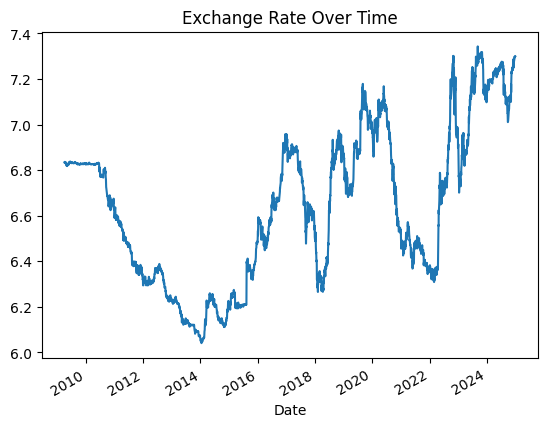

In [ ]:
#STATIONARITY CHECK
df['Exchange_Rate'].plot(title='Exchange Rate Over Time')
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Exchange_Rate'].dropna())
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
#since p-value: 0.5153 → Fail to reject null → ❌ Not stationary
#our d in arima will be 1


In [ ]:
def load_data(file_path, target_column='US-CNY Exchange rate'):
    import pandas as pd

    try:
        df = pd.read_csv(file_path)
        print(f"✅ Loaded data with columns: {', '.join(df.columns)}")

        # Infer date column
        date_cols = [col for col in df.columns if 'date' in col.lower()]
        date_col = date_cols[0] if date_cols else df.columns[0]

        df = df.rename(columns={date_col: 'Date', target_column: 'Exchange_Rate'})
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
        df = df.set_index('Date')
        df = df.sort_index()

        if df.index.duplicated().any():
            print(f"⚠️ {df.index.duplicated().sum()} duplicated dates found. Averaging values.")
            df = df.groupby(df.index).mean()

        if df['Exchange_Rate'].isna().any():
            print("⚠️ Missing values in Exchange_Rate column. Interpolating...")
            df['Exchange_Rate'] = df['Exchange_Rate'].interpolate(method='time')

        print(f"✅ Final dataset from {df.index.min().date()} to {df.index.max().date()} with {len(df)} records.")
        return df

    except Exception as e:
        print(f"❌ Error loading data: {str(e)}")
        return None
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
import traceback

def tune_arima_parameters(train_val_series, steps, true_values, param_grid):
    best_score = float('inf')
    best_order = None
    attempted = 0
    succeeded = 0

    print("\n🔍 Tuning ARIMA hyperparameters...")

    for params in ParameterGrid(param_grid):
        order = (params['p'], params['d'], params['q'])
        attempted += 1

        try:
            model = ARIMA(train_val_series, order=order)
            fitted = model.fit()
            preds = fitted.forecast(steps=steps)

            mse = mean_squared_error(true_values, preds)
            succeeded += 1

            print(f"Tried ARIMA{order} → MSE: {mse:.6f}")

            if mse < best_score:
                best_score = mse
                best_order = order
                print(f"🎯 New best order: {order} with MSE: {mse:.6f}")

        except Exception as e:
            print(f"❌ Failed ARIMA{order}: {repr(e)}")
            traceback.print_exc()
            continue

    print(f"\n✅ Tuning complete. Tried {attempted} combinations, succeeded: {succeeded}")
    print(f"✅ Best ARIMA order: {best_order} with MSE: {best_score:.6f}" if best_order else "⚠️ No valid model found.")

    return best_order, best_score


def rolling_window_arima_one_step(df, param_grid):
    from statsmodels.tsa.arima.model import ARIMA
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import matplotlib.pyplot as plt
    import os

    os.makedirs("predictions_arima_daily", exist_ok=True)
    os.makedirs("plots_arima_daily", exist_ok=True)

    results = []
    start_train_year = 2009

    for window in range(1, 7):  # 6 windows
        train_start = start_train_year
        train_end = train_start + 6
        val_start = train_end + 1
        val_end = val_start + 2
        test_year = val_end + 1

        print(f"\n🔁 Window {window}: Train {train_start}-{train_end}, Validation {val_start}-{val_end}, Test {test_year}")

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]['Exchange_Rate']
        val_data = df[(df.index.year >= val_start) & (df.index.year <= val_end)]['Exchange_Rate']
        test_data = df[df.index.year == test_year]['Exchange_Rate']

        if train_data.empty or val_data.empty or test_data.empty:
            print("❌ Skipping window due to missing data.")
            start_train_year += 1
            continue


        # Tune ARIMA on train + validation
        train_val_series = pd.concat([train_data, val_data])
        best_order, _ = tune_arima_parameters(train_val_series, len(val_data), val_data, param_grid)
        print(f"✅ Best ARIMA order: {best_order}")

        predictions, actuals, prediction_dates = [], [], []
        test_index = test_data.index

        for i in range(len(test_index) - 1):  # predict t+1
            end_date = test_index[i]#checked-->ok

            min_date = pd.Timestamp(f"{train_start}-01-01")



            try:
                history = df[(df.index >= min_date) & (df.index <= end_date)]['Exchange_Rate']

                if len(history) < 30 or history.isna().any():
                    raise ValueError("Insufficient or invalid history")

                model = ARIMA(history, order=best_order)
                model_fit = model.fit()
                loc = df.index.get_loc(end_date)
                forecast_date = df.index[loc + 1]
                forecast = model_fit.forecast(steps=1)

                predictions.append(forecast)
                actuals.append(df.loc[forecast_date, 'Exchange_Rate'])
                prediction_dates.append(forecast_date)

            except Exception as e:
              print(f"⚠️ Forecast failed on {end_date.strftime('%Y-%m-%d')}: {repr(e)}")
              continue

        pred_df = pd.DataFrame({
            'Date': prediction_dates,
            'Actual': actuals,
            'Predicted': predictions
        })

        pred_df.to_csv(f"predictions_arima_daily/arima_daily_{test_year}.csv", index=False)

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(pred_df["Date"], pred_df["Actual"], label="Actual", color="blue")
        plt.plot(pred_df["Date"], pred_df["Predicted"], label="Predicted", color="red")
        plt.title(f"ARIMA One-Step Forecast – Test Year {test_year}")
        plt.xlabel("Date")
        plt.ylabel("Exchange Rate")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"plots_arima_daily/arima_daily_plot_{test_year}.png")
        plt.close()

        # Metrics
        mse = mean_squared_error(actuals, predictions)
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)

        results.append({
            "Window": window,
            "Train_Years": f"{train_start}-{train_end}",
            "Validation_Years": f"{val_start}-{val_end}",
            "Test_Year": test_year,
            "Best_Order": best_order,
            "MSE": mse,
            "MAE": mae,
            "R2": r2
        })

        start_train_year += 1

    final_result_df = pd.DataFrame(results)
    final_result_df.to_csv("arima_daily_rolling_metrics.csv", index=False)
    return final_result_df

In [ ]:
param_grid = {
    'p': [0, 1, 2],
    'd': [ 1],
    'q': [0, 1, 2]
}

file_path = '/content/processed_file.csv'
df = load_data(file_path)
results_df = rolling_window_arima_one_step(df, param_grid=param_grid)

✅ Loaded data with columns: Date, CN Fixing Rate, EUR/CNY, CN GDP (Billion USD), Trade Balance(us-cn), US GDP (Billion USD), Unemployment Rate US, US Dollar Index, US 10-Year Treasury Yield, Personal Consumption Expenditures (Real) US, Total Nonfarm Payroll Employment US, GBP/USD, EUR/USD, US-CNY Exchange rate, interest_diff(us-cn), inflation_diff(us-cn), CN GDP (Billion USD)_lagged, US GDP (Billion USD)_lagged, Trade Balance(us-cn)_lagged, Unemployment Rate US_lagged, Personal Consumption Expenditures (Real) US_lagged, Total Nonfarm Payroll Employment US_lagged, inflation_diff(us-cn)_lagged
✅ Final dataset from 2009-04-01 to 2024-12-30 with 3824 records.

🔁 Window 1: Train 2009-2015, Validation 2016-2018, Test 2019

🔍 Tuning ARIMA hyperparameters...
Tried ARIMA(0, 1, 0) → MSE: 0.078958
🎯 New best order: (0, 1, 0) with MSE: 0.078958
Tried ARIMA(0, 1, 1) → MSE: 0.079044
Tried ARIMA(0, 1, 2) → MSE: 0.079157
Tried ARIMA(1, 1, 0) → MSE: 0.079035
Tried ARIMA(1, 1, 1) → MSE: 0.079038
Tried A

Long term prediction with the prediction horizon of 10days


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid
import os
import warnings
warnings.filterwarnings("ignore")

# === Tuning Function (direct t+10 prediction, single fit) ===
def tune_arima_parameters_direct_horizon(train_val_series, validation_series, param_grid, forecast_horizon=10):
    best_score = float('inf')
    best_order = None
    attempted = 0
    succeeded = 0

    print("\n🔍 Tuning ARIMA hyperparameters for direct t+10 prediction (single fit)...")

    for params in ParameterGrid(param_grid):
        order = (params['p'], params['d'], params['q'])
        attempted += 1

        try:
            model = ARIMA(train_val_series, order=order)
            model_fit = model.fit()

            preds = model_fit.forecast(steps=len(validation_series))
            # Compare only t+10 steps
            y_preds = preds[forecast_horizon - 1::forecast_horizon]
            y_true = validation_series[forecast_horizon - 1::forecast_horizon]

            if len(y_preds) != len(y_true):
                continue

            mse = mean_squared_error(y_true, y_preds)
            succeeded += 1

            print(f"Tried ARIMA{order} → MSE@t+10: {mse:.6f}")

            if mse < best_score:
                best_score = mse
                best_order = order
                print(f"🎯 New best order: {order} with MSE@t+10: {mse:.6f}")

        except Exception as e:
            print(f"❌ Failed ARIMA{order}: {repr(e)}")
            continue

    print(f"\n✅ Tuning complete. Tried {attempted}, succeeded: {succeeded}")
    print(f"✅ Best ARIMA order: {best_order} with MSE@t+10: {best_score:.6f}" if best_order else "⚠️ No valid model found.")
    return best_order, best_score


# === Rolling Forecast Function ===
def rolling_window_arima_direct_t10(df, param_grid):
    results = []
    start_train_year = 2009

    os.makedirs("predictions_arima_t10", exist_ok=True)
    os.makedirs("plots_arima_t10", exist_ok=True)

    for window in range(1, 7):
        train_start = start_train_year
        train_end = train_start + 6
        val_start = train_end + 1
        val_end = val_start + 2
        test_year = val_end + 1

        print(f"\n🪟 Window {window}: Train {train_start}-{train_end}, Val {val_start}-{val_end}, Test {test_year}")

        train = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        val = df[(df.index.year >= val_start) & (df.index.year <= val_end)]
        test = df[df.index.year == test_year]

        if train.empty or val.empty or test.empty:
            print("⚠️ Skipping due to insufficient data.")
            start_train_year += 1
            continue

        train_val = pd.concat([train, val])
        best_order, _ = tune_arima_parameters_direct_horizon(
            train_val_series=train_val['Exchange_Rate'],
            validation_series=val['Exchange_Rate'],
            param_grid=param_grid,
            forecast_horizon=10
        )

        predictions, actuals, prediction_dates = [], [], []
        test_index = test.index
        forecast_horizon = 10

        for i in range(len(test_index) - forecast_horizon):
            end_date = test_index[i]
            min_date = pd.Timestamp(f"{train_start}-01-01")

            try:
                history = df[(df.index >= min_date) & (df.index <= end_date)]['Exchange_Rate']
                if len(history) < 30 or history.isna().any():
                    raise ValueError("Insufficient or invalid history")

                model = ARIMA(history, order=best_order)
                model_fit = model.fit()

                preds = model_fit.forecast(steps=forecast_horizon)
                forecast = preds.iloc[-1]

                loc = df.index.get_loc(end_date)
                forecast_date = df.index[loc + forecast_horizon]
                actual = df.loc[forecast_date, 'Exchange_Rate']

                predictions.append(forecast)
                actuals.append(actual)
                prediction_dates.append(forecast_date)

            except Exception as e:
                print(f"⚠️ Forecast failed on {end_date.strftime('%Y-%m-%d')}: {repr(e)}")
                continue

        # Save prediction results
        pred_df = pd.DataFrame({
            'Date': prediction_dates,
            'Actual': actuals,
            'Predicted': predictions
        })
        pred_df.to_csv(f"predictions_arima_t10/arima_t10_{test_year}.csv", index=False)

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(pred_df["Date"], pred_df["Actual"], label="Actual", color="blue")
        plt.plot(pred_df["Date"], pred_df["Predicted"], label="Predicted", color="red")
        plt.title(f"ARIMA Direct t+10 Forecast – Test Year {test_year}")
        plt.xlabel("Date"); plt.ylabel("Exchange Rate")
        plt.legend(); plt.grid(True); plt.tight_layout()
        plt.savefig(f"plots_arima_t10/arima_t10_plot_{test_year}.png")
        plt.close()

        # Metrics
        mse = mean_squared_error(actuals, predictions)
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)

        results.append({
            "Window": window,
            "Train_Years": f"{train_start}-{train_end}",
            "Validation_Years": f"{val_start}-{val_end}",
            "Test_Year": test_year,
            "Best_Order": best_order,
            "MSE": mse,
            "MAE": mae,
            "R2": r2
        })

        start_train_year += 1

    final_result_df = pd.DataFrame(results)
    final_result_df.to_csv("arima_direct_t10_metrics.csv", index=False)
    return final_result_df


In [ ]:
param_grid = {
    'p': [0, 1, 2],
    'd': [1],
    'q': [0, 1, 2]
}

file_path = '/content/processed_file.csv'
df = load_data(file_path)

results_df = rolling_window_arima_direct_t10(df, param_grid=param_grid)


✅ Loaded data with columns: Date, CN Fixing Rate, EUR/CNY, CN GDP (Billion USD), Trade Balance(us-cn), US GDP (Billion USD), Unemployment Rate US, US Dollar Index, US 10-Year Treasury Yield, Personal Consumption Expenditures (Real) US, Total Nonfarm Payroll Employment US, GBP/USD, EUR/USD, US-CNY Exchange rate, interest_diff(us-cn), inflation_diff(us-cn), CN GDP (Billion USD)_lagged, US GDP (Billion USD)_lagged, Trade Balance(us-cn)_lagged, Unemployment Rate US_lagged, Personal Consumption Expenditures (Real) US_lagged, Total Nonfarm Payroll Employment US_lagged, inflation_diff(us-cn)_lagged
✅ Final dataset from 2009-04-01 to 2024-12-30 with 3824 records.

🪟 Window 1: Train 2009-2015, Val 2016-2018, Test 2019

🔍 Tuning ARIMA hyperparameters for direct t+10 prediction (single fit)...
Tried ARIMA(0, 1, 0) → MSE@t+10: 0.081050
🎯 New best order: (0, 1, 0) with MSE@t+10: 0.081050
Tried ARIMA(0, 1, 1) → MSE@t+10: 0.081138
Tried ARIMA(0, 1, 2) → MSE@t+10: 0.081251
Tried ARIMA(1, 1, 0) → MSE@t

SARIMAX Modeling

In [ ]:
#next day prediction
import numpy as np
import pandas as pd  # ✅ You missed this
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid
import os
import warnings
warnings.filterwarnings('ignore')

# === Load data ===
def load_data(file_path, target_column='US-CNY Exchange rate'):
    try:
        df = pd.read_csv(file_path)
        print(f"Columns in dataset: {', '.join(df.columns)}")
        if target_column not in df.columns:
            print(f"WARNING: Target column '{target_column}' not found in data.")
            return None, None

        date_cols = [col for col in df.columns if 'date' in col.lower()]
        date_col = date_cols[0] if date_cols else df.columns[0]

        df = df.rename(columns={date_col: 'Date', target_column: 'Exchange_Rate'})
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
        df = df.set_index('Date')

        if df.index.duplicated().any():
            print(f"Warning: {df.index.duplicated().sum()} duplicated dates found")
            df = df.groupby(df.index).mean()

        df = df.sort_index()

        if df['Exchange_Rate'].isna().any():
            df['Exchange_Rate'] = df['Exchange_Rate'].interpolate(method='time')

        exog_columns = [col for col in df.columns if col != 'Exchange_Rate']
        return df['Exchange_Rate'], df[exog_columns]

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, None

# === Tune SARIMAX ===
from sklearn.preprocessing import StandardScaler
def tune_sarimax_parameters(train_val_series, exog_data, steps, exog_future, true_values, param_grid, early_stop_rounds=10):
    best_score = float('inf')
    best_order = None
    best_seasonal_order = None
    attempted = 0
    succeeded = 0
    no_improve_count = 0  # <-- for early stopping

    print("\nTuning SARIMAX hyperparameters...")

    for params in ParameterGrid(param_grid):
        if no_improve_count >= early_stop_rounds:
            print(f"⏹️ Early stopping triggered after {no_improve_count} non-improving combinations.")
            break

        attempted += 1
        try:
            order = (params['p'], params['d'], params['q'])
            seasonal_order = (params['P'], params['D'], params['Q'], params['S'])
            model = SARIMAX(train_val_series, exog=exog_data, order=order, seasonal_order=seasonal_order)
            fitted = model.fit(disp=False)
            preds = fitted.forecast(steps=steps, exog=exog_future)

            mse = mean_squared_error(true_values, preds)
            succeeded += 1

            if mse < best_score:
                best_score = mse
                best_order = order
                best_seasonal_order = seasonal_order
                no_improve_count = 0  # reset
                print(f"✅ New best: order={order}, seasonal={seasonal_order}, MSE={mse:.6f}")
            else:
                no_improve_count += 1

        except Exception as e:
            print(f"❌ Failed: order={order}, seasonal={seasonal_order} => {str(e)}")
            no_improve_count += 1

    print(f"Tuning complete. Tried {attempted}, succeeded: {succeeded}")
    return best_order, best_seasonal_order, best_score


def rolling_window_sarimax(df, start_train_year, end_train_year, val_years, test_year, param_grid):
    results_df = pd.DataFrame(columns=['Window', 'Training_Period', 'Validation_Period',
                                       'Test_Period', 'Best_Order', 'Best_Seasonal_Order', 'MSE', 'MAE', 'R2'])
    window = 1
    os.makedirs("predictions_sarimax", exist_ok=True)
    os.makedirs("plots_sarimax", exist_ok=True)

    while test_year <= 2024:
        print(f"\n🪟 Window {window}: Train {start_train_year}-{end_train_year}, Val {val_years}, Test {test_year}")

        train = df[(df.index.year >= start_train_year) & (df.index.year <= end_train_year)]
        val = df[df.index.year.isin(val_years)]
        test = df[df.index.year == test_year]

        if train.empty or val.empty or test.empty:
            print("⚠️ Skipping due to insufficient data.")
            start_train_year += 1
            end_train_year += 1
            val_years = [y + 1 for y in val_years]
            test_year += 1
            window += 1
            continue

        train_val = pd.concat([train, val])
        exog_train_val_raw = train_val.drop(columns='Exchange_Rate')
        exog_test_raw = test.drop(columns='Exchange_Rate')

        scaler = StandardScaler()
        scaler.fit(exog_train_val_raw)

        exog_train_val = pd.DataFrame(scaler.transform(exog_train_val_raw), columns=exog_train_val_raw.columns, index=exog_train_val_raw.index)
        exog_test = pd.DataFrame(scaler.transform(exog_test_raw), columns=exog_test_raw.columns, index=exog_test_raw.index)

        best_order, best_seasonal_order, _ = tune_sarimax_parameters(
            train_val['Exchange_Rate'], exog_train_val,
            steps=len(val), exog_future=exog_train_val.loc[val.index],
            true_values=val['Exchange_Rate'], param_grid=param_grid, early_stop_rounds=10
        )

        if best_order is None:
            print("❗Using fallback parameters (1,1,1)(1,1,1,12)")
            best_order = (1, 1, 1)
            best_seasonal_order = (1, 1, 1, 12)

        predictions, actuals, prediction_dates = [], [], []
        test_index = test.index

        for i in range(len(test_index) - 1):
            end_date = test_index[i]
            next_date = test_index[i + 1]

            try:
                y_history = df.loc[df.index <= end_date, 'Exchange_Rate']
                x_history = df.loc[df.index <= end_date].drop(columns='Exchange_Rate')
                x_next = df.loc[[next_date]].drop(columns='Exchange_Rate')

                if len(y_history) < 30 or x_history.isna().any().any() or x_next.isna().any().any():
                    raise ValueError("Insufficient or invalid history")

                model = SARIMAX(y_history, exog=x_history,
                                order=best_order, seasonal_order=best_seasonal_order)
                model_fit = model.fit(disp=False)

                pred = model_fit.forecast(steps=1, exog=x_next).iloc[0]
                actual = df.loc[next_date, 'Exchange_Rate']

                predictions.append(pred)
                actuals.append(actual)
                prediction_dates.append(next_date)

            except Exception as e:
                print(f"⚠️ One-step forecast failed on {end_date.strftime('%Y-%m-%d')}: {repr(e)}")
                continue

        pred_df = pd.DataFrame({
            'Date': prediction_dates,
            'Actual': actuals,
            'Predicted': predictions
        })

        pred_df.to_csv(f"predictions_sarimax/sarimax_predictions_{test_year}.csv", index=False)

        plt.figure(figsize=(12, 6))
        plt.plot(pred_df["Date"], pred_df["Actual"], label="Actual", color="blue")
        plt.plot(pred_df["Date"], pred_df["Predicted"], label="Predicted", color="red")
        plt.title(f'SARIMAX One-Step Forecast - {test_year}')
        plt.xlabel('Date'); plt.ylabel('Exchange Rate')
        plt.legend(); plt.grid(True); plt.tight_layout()
        plt.savefig(f"plots_sarimax/sarimax_prediction_plot_{test_year}.png")
        plt.close()

        mse = mean_squared_error(actuals, predictions)
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)

        results_df.loc[len(results_df)] = [
            window,
            f"{start_train_year}-{end_train_year}",
            f"{val_years[0]}-{val_years[-1]}",
            test_year,
            best_order,
            best_seasonal_order,
            mse,
            mae,
            r2
        ]

        start_train_year += 1
        end_train_year += 1
        val_years = [y + 1 for y in val_years]
        test_year += 1
        window += 1

    results_df.to_csv('sarimax_rolling_results_long.csv', index=False)
    return results_df

# === Run code ===
file_path = '/content/processed_file.csv'
target_series, exog_data = load_data(file_path)

# Combine target and raw (unscaled) exog — scaling happens later per window
df = pd.concat([target_series, exog_data], axis=1)

param_grid = {
    'p': [0, 1, 2],
    'd': [ 1],
    'q': [0, 1],
    'P': [0, 1],
    'D': [0, 1],
    'Q': [0, 1],
    'S': [12]
}

results = rolling_window_sarimax(df, 2009, 2015, [2016, 2017, 2018], 2019, param_grid)

Columns in dataset: Date, CN Fixing Rate, EUR/CNY, CN GDP (Billion USD), Trade Balance(us-cn), US GDP (Billion USD), Unemployment Rate US, US Dollar Index, US 10-Year Treasury Yield, Personal Consumption Expenditures (Real) US, Total Nonfarm Payroll Employment US, GBP/USD, EUR/USD, US-CNY Exchange rate, interest_diff(us-cn), inflation_diff(us-cn), CN GDP (Billion USD)_lagged, US GDP (Billion USD)_lagged, Trade Balance(us-cn)_lagged, Unemployment Rate US_lagged, Personal Consumption Expenditures (Real) US_lagged, Total Nonfarm Payroll Employment US_lagged, inflation_diff(us-cn)_lagged

🪟 Window 1: Train 2009-2015, Val [2016, 2017, 2018], Test 2019

Tuning SARIMAX hyperparameters...
✅ New best: order=(0, 1, 0), seasonal=(0, 0, 0, 12), MSE=0.020233
✅ New best: order=(0, 1, 1), seasonal=(0, 0, 0, 12), MSE=0.015014
✅ New best: order=(1, 1, 1), seasonal=(0, 0, 0, 12), MSE=0.012253
⏹️ Early stopping triggered after 10 non-improving combinations.
Tuning complete. Tried 14, succeeded: 14

🪟 Win

In [ ]:
# next 10 days prediction
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.statespace.sarimax import SARIMAX
# === Load data ===
def load_data(file_path, target_column='US-CNY Exchange rate'):
    try:
        df = pd.read_csv(file_path)
        print(f"Columns in dataset: {', '.join(df.columns)}")
        if target_column not in df.columns:
            print(f"WARNING: Target column '{target_column}' not found in data.")
            return None, None

        date_cols = [col for col in df.columns if 'date' in col.lower()]
        date_col = date_cols[0] if date_cols else df.columns[0]

        df = df.rename(columns={date_col: 'Date', target_column: 'Exchange_Rate'})
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
        df = df.set_index('Date')

        if df.index.duplicated().any():
            print(f"Warning: {df.index.duplicated().sum()} duplicated dates found")
            df = df.groupby(df.index).mean()

        df = df.sort_index()

        if df['Exchange_Rate'].isna().any():
            df['Exchange_Rate'] = df['Exchange_Rate'].interpolate(method='time')

        exog_columns = [col for col in df.columns if col != 'Exchange_Rate']
        return df['Exchange_Rate'], df[exog_columns]

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, None
def tune_sarimax_parameters(train_val_series, exog_data, steps, exog_future, true_values, param_grid, early_stop_rounds=10):
    best_score = float('inf')
    best_order = None
    best_seasonal_order = None
    attempted = 0
    succeeded = 0
    no_improve_count = 0

    print("\n🔍 Tuning SARIMAX hyperparameters...")

    for params in ParameterGrid(param_grid):
        if no_improve_count >= early_stop_rounds:
            print(f"⏹️ Early stopping triggered after {no_improve_count} non-improving combinations.")
            break

        attempted += 1
        try:
            order = (params['p'], params['d'], params['q'])
            seasonal_order = (params['P'], params['D'], params['Q'], params['S'])

            model = SARIMAX(train_val_series, exog=exog_data, order=order, seasonal_order=seasonal_order)
            fitted = model.fit(disp=False)

            # Forecast 10 steps ahead
            preds = fitted.forecast(steps=steps, exog=exog_future)

            # For 10-step-ahead eval, use only the final step
            if steps == 10:
                preds = preds.iloc[-1:]
                true_values = true_values.iloc[-1:]

            mse = mean_squared_error(true_values, preds)
            succeeded += 1

            if mse < best_score:
                best_score = mse
                best_order = order
                best_seasonal_order = seasonal_order
                no_improve_count = 0  # reset
                print(f"✅ New best: order={order}, seasonal={seasonal_order}, MSE={mse:.6f}")
            else:
                no_improve_count += 1

        except Exception as e:
            print(f"❌ Failed: order={order}, seasonal={seasonal_order} => {str(e)}")
            no_improve_count += 1

    print(f"✅ Tuning complete. Tried {attempted}, succeeded: {succeeded}")
    return best_order, best_seasonal_order, best_score
def rolling_window_sarimax(df, start_train_year, end_train_year, val_years, test_year, param_grid):
    results_df = pd.DataFrame(columns=['Window', 'Training_Period', 'Validation_Period',
                                       'Test_Period', 'Best_Order', 'Best_Seasonal_Order', 'MSE', 'MAE', 'R2'])
    window = 1
    os.makedirs("predictions_sarimax_long", exist_ok=True)
    os.makedirs("plots_sarimax_long", exist_ok=True)

    while test_year <= 2024:
        print(f"\n🪟 Window {window}: Train {start_train_year}-{end_train_year}, Val {val_years}, Test {test_year}")

        train = df[(df.index.year >= start_train_year) & (df.index.year <= end_train_year)]
        val = df[df.index.year.isin(val_years)]
        test = df[df.index.year == test_year]

        if train.empty or val.empty or test.empty:
            print("⚠️ Skipping due to insufficient data.")
            start_train_year += 1
            end_train_year += 1
            val_years = [y + 1 for y in val_years]
            test_year += 1
            window += 1
            continue

        train_val = pd.concat([train, val])
        exog_train_val_raw = train_val.drop(columns='Exchange_Rate')
        exog_test_raw = test.drop(columns='Exchange_Rate')

        scaler = StandardScaler()
        scaler.fit(exog_train_val_raw)

        exog_train_val = pd.DataFrame(scaler.transform(exog_train_val_raw), columns=exog_train_val_raw.columns, index=exog_train_val_raw.index)
        exog_test = pd.DataFrame(scaler.transform(exog_test_raw), columns=exog_test_raw.columns, index=exog_test_raw.index)

        best_order, best_seasonal_order, _ = tune_sarimax_parameters(
            train_val['Exchange_Rate'], exog_train_val,
            steps=len(val), exog_future=exog_train_val.loc[val.index],
            true_values=val['Exchange_Rate'], param_grid=param_grid, early_stop_rounds=10
        )

        if best_order is None:
            print("❗Using fallback parameters (1,1,1)(1,1,1,12)")
            best_order = (1, 1, 1)
            best_seasonal_order = (1, 1, 1, 12)

        predictions, actuals, prediction_dates = [], [], []
        test_index = test.index

        for i in range(len(test_index) - 10):  # Ensure we have room for 10-day ahead
            end_date = test_index[i]
            next_date = test_index[i + 1]

            try:
                y_history = df.loc[df.index <= end_date, 'Exchange_Rate']
                x_history = df.loc[df.index <= end_date].drop(columns='Exchange_Rate')

                if len(y_history) < 30 or len(x_history) < 10 or x_history.isna().any().any():
                    raise ValueError("Insufficient or invalid history")

                # Use last 10 known X rows as future X
                last_10_x = x_history.iloc[-10:].copy()
                x_future = last_10_x.copy()
                x_future.index = pd.date_range(start=next_date, periods=10, freq='B')

                model = SARIMAX(y_history, exog=x_history,
                                order=best_order, seasonal_order=best_seasonal_order)
                model_fit = model.fit(disp=False)

                pred = model_fit.forecast(steps=10, exog=x_future).iloc[-1]  # y_{t+10}
                actual = df.loc[test_index[i + 10], 'Exchange_Rate']

                predictions.append(pred)
                actuals.append(actual)
                prediction_dates.append(test_index[i + 10])

            except Exception as e:
                print(f"⚠️ 10-step forecast failed on {end_date.strftime('%Y-%m-%d')}: {repr(e)}")
                continue

        pred_df = pd.DataFrame({
            'Date': prediction_dates,
            'Actual': actuals,
            'Predicted': predictions
        })

        pred_df.to_csv(f"predictions_sarimax_long/sarimax_predictions_{test_year}_long.csv", index=False)

        plt.figure(figsize=(12, 6))
        plt.plot(pred_df["Date"], pred_df["Actual"], label="Actual", color="blue")
        plt.plot(pred_df["Date"], pred_df["Predicted"], label="Predicted", color="red")
        plt.title(f'SARIMAX 10-Step Forecast - {test_year}')
        plt.xlabel('Date'); plt.ylabel('Exchange Rate')
        plt.legend(); plt.grid(True); plt.tight_layout()
        plt.savefig(f"plots_sarimax_long/sarimax_prediction_plot_{test_year}_long.png")
        plt.close()

        mse = mean_squared_error(actuals, predictions)
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)

        results_df.loc[len(results_df)] = [
            window,
            f"{start_train_year}-{end_train_year}",
            f"{val_years[0]}-{val_years[-1]}",
            test_year,
            best_order,
            best_seasonal_order,
            mse,
            mae,
            r2
        ]

        start_train_year += 1
        end_train_year += 1
        val_years = [y + 1 for y in val_years]
        test_year += 1
        window += 1

    results_df.to_csv('sarimax_rolling_results_10_day.csv', index=False)
    return results_df


In [ ]:
param_grid = {
    'p': [0, 1, 2],
    'd': [1],
    'q': [0, 1],
    'P': [0, 1],
    'D': [0, 1],
    'Q': [0, 1],
    'S': [12]  # Seasonal period (monthly)
}
file_path = '/content/processed_file.csv'
target_series, exog_data = load_data(file_path)
df = pd.concat([target_series, exog_data], axis=1)
results = rolling_window_sarimax(
    df=df,
    start_train_year=2009,
    end_train_year=2015,
    val_years=[2016, 2017, 2018],
    test_year=2019,
    param_grid=param_grid
)


Columns in dataset: Date, CN Fixing Rate, EUR/CNY, CN GDP (Billion USD), Trade Balance(us-cn), US GDP (Billion USD), Unemployment Rate US, US Dollar Index, US 10-Year Treasury Yield, Personal Consumption Expenditures (Real) US, Total Nonfarm Payroll Employment US, GBP/USD, EUR/USD, US-CNY Exchange rate, interest_diff(us-cn), inflation_diff(us-cn), CN GDP (Billion USD)_lagged, US GDP (Billion USD)_lagged, Trade Balance(us-cn)_lagged, Unemployment Rate US_lagged, Personal Consumption Expenditures (Real) US_lagged, Total Nonfarm Payroll Employment US_lagged, inflation_diff(us-cn)_lagged

🪟 Window 1: Train 2009-2015, Val [2016, 2017, 2018], Test 2019

🔍 Tuning SARIMAX hyperparameters...
✅ New best: order=(0, 1, 0), seasonal=(0, 0, 0, 12), MSE=0.020233
✅ New best: order=(0, 1, 1), seasonal=(0, 0, 0, 12), MSE=0.015014
✅ New best: order=(1, 1, 1), seasonal=(0, 0, 0, 12), MSE=0.012253
⏹️ Early stopping triggered after 10 non-improving combinations.
✅ Tuning complete. Tried 14, succeeded: 14

🪟

XGBOOSTING


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid
from xgboost import XGBRegressor, plot_importance
import os
import warnings
warnings.filterwarnings('ignore')

def load_data(file_path, target_column='US-CNY Exchange rate'):
    try:
        df = pd.read_csv(file_path)
        print(f"Columns in dataset: {', '.join(df.columns)}")
        if target_column not in df.columns:
            print(f"WARNING: Target column '{target_column}' not found in data.")
            return None

        date_cols = [col for col in df.columns if 'date' in col.lower()]
        date_col = date_cols[0] if date_cols else df.columns[0]

        df = df.rename(columns={date_col: 'Date', target_column: 'Exchange_Rate'})
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
        df = df.set_index('Date')

        if df.index.duplicated().any():
            print(f"Warning: {df.index.duplicated().sum()} duplicated dates found")
            df = df.groupby(df.index).mean()

        df = df.sort_index()

        if df['Exchange_Rate'].isna().any():
            df['Exchange_Rate'] = df['Exchange_Rate'].interpolate(method='time')

        return df
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

def tune_xgboost_parameters(X_train, y_train, X_val, y_val, param_grid):
    best_score = float('inf')
    best_params = None
    attempted = 0
    succeeded = 0

    print("\nTuning XGBoost hyperparameters...")

    for params in ParameterGrid(param_grid):
        attempted += 1
        try:
            model = XGBRegressor(objective='reg:squarederror', **params)
            model.fit(X_train, y_train)
            preds = model.predict(X_val)
            mse = mean_squared_error(y_val, preds)
            succeeded += 1

            if mse < best_score:
                best_score = mse
                best_params = params
                print(f"New best params: {params} with MSE: {mse:.6f}")

        except Exception as e:
            print(f"Failed params: {params} => {str(e)}")
            continue

    print(f"Tuning complete. Tried {attempted} combos, succeeded: {succeeded}")
    return best_params, best_score

def compute_overall_feature_importance(feature_importance_dict):
    overall_importance = {feature: np.mean(importance) for feature, importance in feature_importance_dict.items()}
    sorted_importance = sorted(overall_importance.items(), key=lambda x: x[1], reverse=True)
    print("\nOverall Feature Importance:")
    for feature, importance in sorted_importance:
        print(f"{feature}: {importance:.4f}")
    return sorted_importance

def rolling_window_xgboost(df, start_train_year, end_train_year, val_years, test_year, param_grid):
    results_df = pd.DataFrame(columns=['Window', 'Training_Period', 'Validation_Period',
                                       'Test_Period', 'Best_Params', 'MSE', 'MAE', 'R2'])
    feature_importance_dict = {}
    window = 1

    os.makedirs("predictions", exist_ok=True)
    os.makedirs("plots", exist_ok=True)

    while test_year <= 2024:
        print(f"\nWindow {window}: Train {start_train_year}-{end_train_year}, Validation {val_years[0]}-{val_years[-1]}, Test {test_year}")

        train_data = df[(df.index.year >= start_train_year) & (df.index.year <= end_train_year)]
        val_data = df[df.index.year.isin(val_years)]
        test_data = df[df.index.year == test_year]

        if train_data.empty or val_data.empty or test_data.empty:
            print("Insufficient data. Skipping window.")
            start_train_year += 1
            end_train_year += 1
            val_years = [y + 1 for y in val_years]
            test_year += 1
            window += 1
            continue

        X_train, y_train = train_data.drop(columns='Exchange_Rate'), train_data['Exchange_Rate']
        X_val, y_val = val_data.drop(columns='Exchange_Rate'), val_data['Exchange_Rate']
        X_test, y_test = test_data.drop(columns='Exchange_Rate'), test_data['Exchange_Rate']

        best_params, best_score = tune_xgboost_parameters(X_train, y_train, X_val, y_val, param_grid)

        if best_params is None:
            print("No valid params found. Using default settings.")
            best_params = {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}

        model = XGBRegressor(objective='reg:squarederror', **best_params)
        model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
        predictions = model.predict(X_test)

        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        feature_importance = model.feature_importances_
        for feature, importance in zip(X_train.columns, feature_importance):
            if feature in feature_importance_dict:
                feature_importance_dict[feature].append(importance)
            else:
                feature_importance_dict[feature] = [importance]

        results_df.loc[len(results_df)] = [
            window,
            f"{start_train_year}-{end_train_year}",
            f"{val_years[0]}-{val_years[-1]}",
            test_year,
            best_params,
            mse,
            mae,
            r2
        ]

        # Save both actual and predicted values to CSV
        test_df = pd.DataFrame({
            'Date': test_data.index,
            'Actual': y_test,
            'Predicted': predictions
        })
        test_df.to_csv(f"predictions/xgboost_predictions_{test_year}.csv", index=False)

        # Create a plot for actual vs predicted
        plt.figure(figsize=(12, 6))
        plt.plot(test_data.index, y_test, label='Actual', color='blue')
        plt.plot(test_data.index, predictions, label='Predicted', color='red')
        plt.title(f'XGBoost Prediction - Test Year {test_year}')
        plt.xlabel('Date')
        plt.ylabel('Exchange Rate')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"plots/xgboost_prediction_plot_{test_year}.png")
        plt.close()

        start_train_year += 1
        end_train_year += 1
        val_years = [y + 1 for y in val_years]
        test_year += 1
        window += 1

    overall_importance = compute_overall_feature_importance(feature_importance_dict)
    results_df.to_csv('xgboost_rolling_results.csv', index=False)
    return results_df, overall_importance

In [ ]:

file_path = '/content/processed_file.csv'
df = load_data(file_path)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}
results = rolling_window_xgboost(df, 2009, 2015, [2016, 2017, 2018], 2019, param_grid)


Columns in dataset: Date, CN Fixing Rate, EUR/CNY, CN GDP (Billion USD), Trade Balance(us-cn), US GDP (Billion USD), Unemployment Rate US, US Dollar Index, US 10-Year Treasury Yield, Personal Consumption Expenditures (Real) US, Total Nonfarm Payroll Employment US, GBP/USD, EUR/USD, US-CNY Exchange rate, interest_diff(us-cn), inflation_diff(us-cn), CN GDP (Billion USD)_lagged, US GDP (Billion USD)_lagged, Trade Balance(us-cn)_lagged, Unemployment Rate US_lagged, Personal Consumption Expenditures (Real) US_lagged, Total Nonfarm Payroll Employment US_lagged, inflation_diff(us-cn)_lagged

Window 1: Train 2009-2015, Validation 2016-2018, Test 2019

Tuning XGBoost hyperparameters...
New best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100} with MSE: 0.023463
New best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200} with MSE: 0.008308
New best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200} with MSE: 0.008216
New best params: {'lear

In [ ]:
file_path = '/content/shifted_features_10day_ahead.csv'
df = load_data(file_path)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}
results = rolling_window_xgboost(df, 2009, 2015, [2016, 2017, 2018], 2019, param_grid)


Columns in dataset: Date, US-CNY Exchange rate, CN Fixing Rate, CN GDP (Billion USD), CN GDP (Billion USD)_lagged, EUR/CNY, EUR/USD, GBP/USD, Personal Consumption Expenditures (Real) US, Personal Consumption Expenditures (Real) US_lagged, Total Nonfarm Payroll Employment US, Total Nonfarm Payroll Employment US_lagged, Trade Balance(us-cn), Trade Balance(us-cn)_lagged, US 10-Year Treasury Yield, US Dollar Index, US GDP (Billion USD), US GDP (Billion USD)_lagged, Unemployment Rate US, Unemployment Rate US_lagged, inflation_diff(us-cn), inflation_diff(us-cn)_lagged, interest_diff(us-cn)

Window 1: Train 2009-2015, Validation 2016-2018, Test 2019

Tuning XGBoost hyperparameters...
New best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100} with MSE: 0.057881
New best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200} with MSE: 0.041593
New best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200} with MSE: 0.027173
New best params: {'lear

LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product
import os
import warnings
warnings.filterwarnings('ignore')

def load_data(file_path, target_column='US-CNY Exchange rate'):
    try:
        df = pd.read_csv(file_path)
        print(f"Columns in dataset: {', '.join(df.columns)}")
        if target_column not in df.columns:
            print(f"WARNING: Target column '{target_column}' not found in data.")
            return None

        date_cols = [col for col in df.columns if 'date' in col.lower()]
        date_col = date_cols[0] if date_cols else df.columns[0]

        df = df.rename(columns={date_col: 'Date', target_column: 'Exchange_Rate'})
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
        df = df.set_index('Date')

        if df.index.duplicated().any():
            print(f"Warning: {df.index.duplicated().sum()} duplicated dates found")
            df = df.groupby(df.index).mean()

        df = df.sort_index()

        if df['Exchange_Rate'].isna().any():
            df['Exchange_Rate'] = df['Exchange_Rate'].interpolate(method='time')

        return df
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

def create_sequences(data, target_column, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length].values)
        y.append(data.iloc[i+sequence_length][target_column])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape, units=50, dropout_rate=0.2):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def tune_lstm_parameters(X_train, y_train, X_val, y_val, param_grid):
    best_score = float('inf')
    best_params = None

    for params in product(*param_grid.values()):
        config = dict(zip(param_grid.keys(), params))
        print(f"Testing LSTM config: {config}")

        model = build_lstm_model((X_train.shape[1], X_train.shape[2]),
                                 units=config['units'],
                                 dropout_rate=config['dropout'])
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=config['epochs'], batch_size=config['batch_size'], verbose=0)
        predictions = model.predict(X_val).flatten()
        mse = mean_squared_error(y_val, predictions)

        if mse < best_score:
            best_score = mse
            best_params = config
            print(f"New best params: {best_params} with MSE: {mse:.6f}")

    return best_params

def rolling_window_lstm(df, start_train_year, end_train_year, val_years, test_year, sequence_length=10, param_grid=None):
    results_df = pd.DataFrame(columns=['Window', 'Training_Period', 'Validation_Period',
                                       'Test_Period', 'Best_Params', 'MSE', 'MAE', 'R2'])
    window = 1

    os.makedirs("predictions", exist_ok=True)
    os.makedirs("plots", exist_ok=True)

    while test_year <= 2024:
        print(f"\nWindow {window}: Train {start_train_year}-{end_train_year}, Validation {val_years[0]}-{val_years[-1]}, Test {test_year}")

        train_data = df[(df.index.year >= start_train_year) & (df.index.year <= end_train_year)]
        val_data = df[df.index.year.isin(val_years)]
        test_data = df[df.index.year == test_year]

        if train_data.empty or val_data.empty or test_data.empty:
            print("Insufficient data. Skipping window.")
            start_train_year += 1
            end_train_year += 1
            val_years = [y + 1 for y in val_years]
            test_year += 1
            window += 1
            continue

        # Separate scalers for X and y
        X_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()

        X_train = train_data.drop(columns=['Exchange_Rate'])
        y_train = train_data[['Exchange_Rate']]
        X_val = val_data.drop(columns=['Exchange_Rate'])
        y_val = val_data[['Exchange_Rate']]
        X_test = test_data.drop(columns=['Exchange_Rate'])
        y_test = test_data[['Exchange_Rate']]

        X_train_scaled = X_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train)
        X_val_scaled = X_scaler.transform(X_val)
        y_val_scaled = y_scaler.transform(y_val)
        X_test_scaled = X_scaler.transform(X_test)
        y_test_scaled = y_scaler.transform(y_test)

        X_train_seq, y_train_seq = create_sequences(pd.DataFrame(np.hstack([X_train_scaled, y_train_scaled]), columns=X_train.columns.tolist() + ['Exchange_Rate']), 'Exchange_Rate', sequence_length)
        X_val_seq, y_val_seq = create_sequences(pd.DataFrame(np.hstack([X_val_scaled, y_val_scaled]), columns=X_val.columns.tolist() + ['Exchange_Rate']), 'Exchange_Rate', sequence_length)
        X_test_seq, y_test_seq = create_sequences(pd.DataFrame(np.hstack([X_test_scaled, y_test_scaled]), columns=X_test.columns.tolist() + ['Exchange_Rate']), 'Exchange_Rate', sequence_length)

        best_params = tune_lstm_parameters(X_train_seq, y_train_seq, X_val_seq, y_val_seq, param_grid)

        model = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]),
                                 units=best_params['units'],
                                 dropout_rate=best_params['dropout'])
        model.fit(X_train_seq, y_train_seq, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

        predictions_scaled = model.predict(X_test_seq).flatten()
        predictions = y_scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
        y_test_true = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

        # DEBUG PRINT TO VERIFY INVERSE VALUES
        print("Sample scaled predictions:", predictions_scaled[:5])
        print("Sample inverse-transformed predictions:", predictions[:5])
        print("Sample inverse-transformed actuals:", y_test_true[:5])

        dates = test_data.index[sequence_length:sequence_length + len(predictions)]
        test_df = pd.DataFrame({
            'Date': dates,
            'Actual': y_test_true,
            'Predicted': predictions
        })
        test_df.to_csv(f"predictions/lstm_predictions_{test_year}.csv", index=False)

        plt.figure(figsize=(12, 6))
        plt.plot(dates, y_test_true, label='Actual', color='blue')
        plt.plot(dates, predictions, label='Predicted', color='red')
        plt.title(f'LSTM Prediction - Test Year {test_year}')
        plt.xlabel('Date')
        plt.ylabel('Exchange Rate')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"plots/lstm_prediction_plot_{test_year}.png")
        plt.close()

        mse = mean_squared_error(y_test_true, predictions)
        mae = mean_absolute_error(y_test_true, predictions)
        r2 = r2_score(y_test_true, predictions)

        results_df.loc[len(results_df)] = [
            window,
            f"{start_train_year}-{end_train_year}",
            f"{val_years[0]}-{val_years[-1]}",
            test_year,
            best_params,
            mse,
            mae,
            r2
        ]

        start_train_year += 1
        end_train_year += 1
        val_years = [y + 1 for y in val_years]
        test_year += 1
        window += 1

    results_df.to_csv('lstm_rolling_results.csv', index=False)
    return results_df

file_path = '/content/processed_file.csv'
df = load_data(file_path)
param_grid = {
    'units': [32, 100],
    'dropout': [0.2, 0.3, 0.5],
    'epochs': [20, 50],
    'batch_size': [16, 64]
}

#results = rolling_window_lstm(df, 2009, 2015, [2016, 2017, 2018], 2019, sequence_length=10, param_grid=param_grid)
results = rolling_window_lstm(
    df,
    start_train_year=2014,
    end_train_year=2020,
    val_years=[2021,2022, 2023],
    test_year=2024,
    sequence_length=10,
    param_grid=param_grid
)

Columns in dataset: Date, CN Fixing Rate, EUR/CNY, CN GDP (Billion USD), Trade Balance(us-cn), US GDP (Billion USD), Unemployment Rate US, US Dollar Index, US 10-Year Treasury Yield, Personal Consumption Expenditures (Real) US, Total Nonfarm Payroll Employment US, GBP/USD, EUR/USD, US-CNY Exchange rate, interest_diff(us-cn), inflation_diff(us-cn), CN GDP (Billion USD)_lagged, US GDP (Billion USD)_lagged, Trade Balance(us-cn)_lagged, Unemployment Rate US_lagged, Personal Consumption Expenditures (Real) US_lagged, Total Nonfarm Payroll Employment US_lagged, inflation_diff(us-cn)_lagged

Window 1: Train 2014-2020, Validation 2021-2023, Test 2024
Testing LSTM config: {'units': 32, 'dropout': 0.2, 'epochs': 20, 'batch_size': 16}
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
New best params: {'units': 32, 'dropout': 0.2, 'epochs': 20, 'batch_size': 16} with MSE: 0.012889
Testing LSTM config: {'units': 32, 'dropout': 0.2, 'epochs': 20, 'batch_size': 64}
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
New b

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product
import os
import warnings
warnings.filterwarnings('ignore')

def load_data(file_path, target_column='US-CNY Exchange rate'):
    try:
        df = pd.read_csv(file_path)
        print(f"Columns in dataset: {', '.join(df.columns)}")
        if target_column not in df.columns:
            print(f"WARNING: Target column '{target_column}' not found in data.")
            return None

        date_cols = [col for col in df.columns if 'date' in col.lower()]
        date_col = date_cols[0] if date_cols else df.columns[0]

        df = df.rename(columns={date_col: 'Date', target_column: 'Exchange_Rate'})
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
        df = df.set_index('Date')

        if df.index.duplicated().any():
            print(f"Warning: {df.index.duplicated().sum()} duplicated dates found")
            df = df.groupby(df.index).mean()

        df = df.sort_index()

        if df['Exchange_Rate'].isna().any():
            df['Exchange_Rate'] = df['Exchange_Rate'].interpolate(method='time')

        return df
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

def create_sequences(data, target_column, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length].values)
        y.append(data.iloc[i+sequence_length][target_column])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape, units=50, dropout_rate=0.2):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def tune_lstm_parameters(X_train, y_train, X_val, y_val, param_grid):
    best_score = float('inf')
    best_params = None

    for params in product(*param_grid.values()):
        config = dict(zip(param_grid.keys(), params))
        print(f"Testing LSTM config: {config}")

        model = build_lstm_model((X_train.shape[1], X_train.shape[2]),
                                 units=config['units'],
                                 dropout_rate=config['dropout'])
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=config['epochs'], batch_size=config['batch_size'], verbose=0)
        predictions = model.predict(X_val).flatten()
        mse = mean_squared_error(y_val, predictions)

        if mse < best_score:
            best_score = mse
            best_params = config
            print(f"New best params: {best_params} with MSE: {mse:.6f}")

    return best_params

def rolling_window_lstm(df, start_train_year, end_train_year, val_years, test_year, sequence_length=10, param_grid=None):
    results_df = pd.DataFrame(columns=['Window', 'Training_Period', 'Validation_Period',
                                       'Test_Period', 'Best_Params', 'MSE', 'MAE', 'R2'])
    window = 1

    os.makedirs("predictions", exist_ok=True)
    os.makedirs("plots", exist_ok=True)

    while test_year <= 2024:
        print(f"\nWindow {window}: Train {start_train_year}-{end_train_year}, Validation {val_years[0]}-{val_years[-1]}, Test {test_year}")

        train_data = df[(df.index.year >= start_train_year) & (df.index.year <= end_train_year)]
        val_data = df[df.index.year.isin(val_years)]
        test_data = df[df.index.year == test_year]

        if train_data.empty or val_data.empty or test_data.empty:
            print("Insufficient data. Skipping window.")
            start_train_year += 1
            end_train_year += 1
            val_years = [y + 1 for y in val_years]
            test_year += 1
            window += 1
            continue

        # Separate scalers for X and y
        X_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()

        X_train = train_data.drop(columns=['Exchange_Rate'])
        y_train = train_data[['Exchange_Rate']]
        X_val = val_data.drop(columns=['Exchange_Rate'])
        y_val = val_data[['Exchange_Rate']]
        X_test = test_data.drop(columns=['Exchange_Rate'])
        y_test = test_data[['Exchange_Rate']]

        X_train_scaled = X_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train)
        X_val_scaled = X_scaler.transform(X_val)
        y_val_scaled = y_scaler.transform(y_val)
        X_test_scaled = X_scaler.transform(X_test)
        y_test_scaled = y_scaler.transform(y_test)

        X_train_seq, y_train_seq = create_sequences(pd.DataFrame(np.hstack([X_train_scaled, y_train_scaled]), columns=X_train.columns.tolist() + ['Exchange_Rate']), 'Exchange_Rate', sequence_length)
        X_val_seq, y_val_seq = create_sequences(pd.DataFrame(np.hstack([X_val_scaled, y_val_scaled]), columns=X_val.columns.tolist() + ['Exchange_Rate']), 'Exchange_Rate', sequence_length)
        X_test_seq, y_test_seq = create_sequences(pd.DataFrame(np.hstack([X_test_scaled, y_test_scaled]), columns=X_test.columns.tolist() + ['Exchange_Rate']), 'Exchange_Rate', sequence_length)

        best_params = tune_lstm_parameters(X_train_seq, y_train_seq, X_val_seq, y_val_seq, param_grid)

        model = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]),
                                 units=best_params['units'],
                                 dropout_rate=best_params['dropout'])
        model.fit(X_train_seq, y_train_seq, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

        predictions_scaled = model.predict(X_test_seq).flatten()
        predictions = y_scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
        y_test_true = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

        # DEBUG PRINT TO VERIFY INVERSE VALUES
        print("Sample scaled predictions:", predictions_scaled[:5])
        print("Sample inverse-transformed predictions:", predictions[:5])
        print("Sample inverse-transformed actuals:", y_test_true[:5])

        dates = test_data.index[sequence_length:sequence_length + len(predictions)]
        test_df = pd.DataFrame({
            'Date': dates,
            'Actual': y_test_true,
            'Predicted': predictions
        })
        test_df.to_csv(f"predictions/lstm_predictions_{test_year}.csv", index=False)

        plt.figure(figsize=(12, 6))
        plt.plot(dates, y_test_true, label='Actual', color='blue')
        plt.plot(dates, predictions, label='Predicted', color='red')
        plt.title(f'LSTM Prediction - Test Year {test_year}')
        plt.xlabel('Date')
        plt.ylabel('Exchange Rate')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"plots/lstm_prediction_plot_{test_year}.png")
        plt.close()

        mse = mean_squared_error(y_test_true, predictions)
        mae = mean_absolute_error(y_test_true, predictions)
        r2 = r2_score(y_test_true, predictions)

        results_df.loc[len(results_df)] = [
            window,
            f"{start_train_year}-{end_train_year}",
            f"{val_years[0]}-{val_years[-1]}",
            test_year,
            best_params,
            mse,
            mae,
            r2
        ]

        start_train_year += 1
        end_train_year += 1
        val_years = [y + 1 for y in val_years]
        test_year += 1
        window += 1

    results_df.to_csv('lstm_rolling_results.csv', index=False)
    return results_df

file_path = '/content/shifted_features_10day_ahead.csv'
df = load_data(file_path)
param_grid = {
    'units': [32, 100],
    'dropout': [0.2, 0.3, 0.5],
    'epochs': [20, 50],
    'batch_size': [16, 64]
}

results = rolling_window_lstm(df, 2009, 2015, [2016, 2017, 2018], 2019, sequence_length=10, param_grid=param_grid)


Columns in dataset: Date, US-CNY Exchange rate, CN Fixing Rate, CN GDP (Billion USD), CN GDP (Billion USD)_lagged, EUR/CNY, EUR/USD, GBP/USD, Personal Consumption Expenditures (Real) US, Personal Consumption Expenditures (Real) US_lagged, Total Nonfarm Payroll Employment US, Total Nonfarm Payroll Employment US_lagged, Trade Balance(us-cn), Trade Balance(us-cn)_lagged, US 10-Year Treasury Yield, US Dollar Index, US GDP (Billion USD), US GDP (Billion USD)_lagged, Unemployment Rate US, Unemployment Rate US_lagged, inflation_diff(us-cn), inflation_diff(us-cn)_lagged, interest_diff(us-cn)

Window 1: Train 2009-2015, Validation 2016-2018, Test 2019
Testing LSTM config: {'units': 32, 'dropout': 0.2, 'epochs': 20, 'batch_size': 16}


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
New best params: {'units': 32, 'dropout': 0.2, 'epochs': 20, 'batch_size': 16} with MSE: 0.050790
Testing LSTM config: {'units': 32, 'dropout': 0.2, 'epochs': 20, 'batch_size': 64}
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Testing LSTM config: {'units': 32, 'dropout': 0.2, 'epochs': 50, 'batch_size': 16}
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Testing LSTM config: {'units': 32, 'dropout': 0.2, 'epochs': 50, 'batch_size': 64}
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
New best params: {'units': 32, 'dropout': 0.2, 'epochs': 50, 'batch_size': 64} with MSE: 0.048609
Testing LSTM config: {'units': 32, 'dropout': 0.3, 'epochs': 20, 'batch_size': 16}
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Testing LSTM config: {'units': 32, 'dropout': 0.3, 'epochs': 20, 'batch_size': 64}
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Testing LSTM config: {'units': 32, 'dropout': 0.3, 'epochs': 50, 'batch_size': 16}
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Testing LSTM config: {'uni

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
New best params: {'units': 32, 'dropout': 0.2, 'epochs': 20, 'batch_size': 16} with MSE: 0.007496
Testing LSTM config: {'units': 32, 'dropout': 0.2, 'epochs': 20, 'batch_size': 64}
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Testing LSTM config: {'units': 32, 'dropout': 0.2, 'epochs': 50, 'batch_size': 16}
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
New best params: {'units': 32, 'dropout': 0.2, 'epochs': 50, 'batch_size': 16} with MSE: 0.007440
Testing LSTM config: {'units': 32, 'dropout': 0.2, 'epochs': 50, 'batch_size': 64}
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Testing LSTM config: {'units': 32, 'dropout': 0.3, 'epochs': 20, 'batch_size': 16}
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Testing LSTM config: {'units': 32, 'dropout': 0.3, 'epochs': 20, 'batch_size': 64}
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Testing LSTM config: {'units': 32, 'dropout': 0.3, 'epochs': 50, 'batch_size': 16}
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Testing LSTM config: {'uni

PLOT GENERATION AND RESULT ANALYSIS

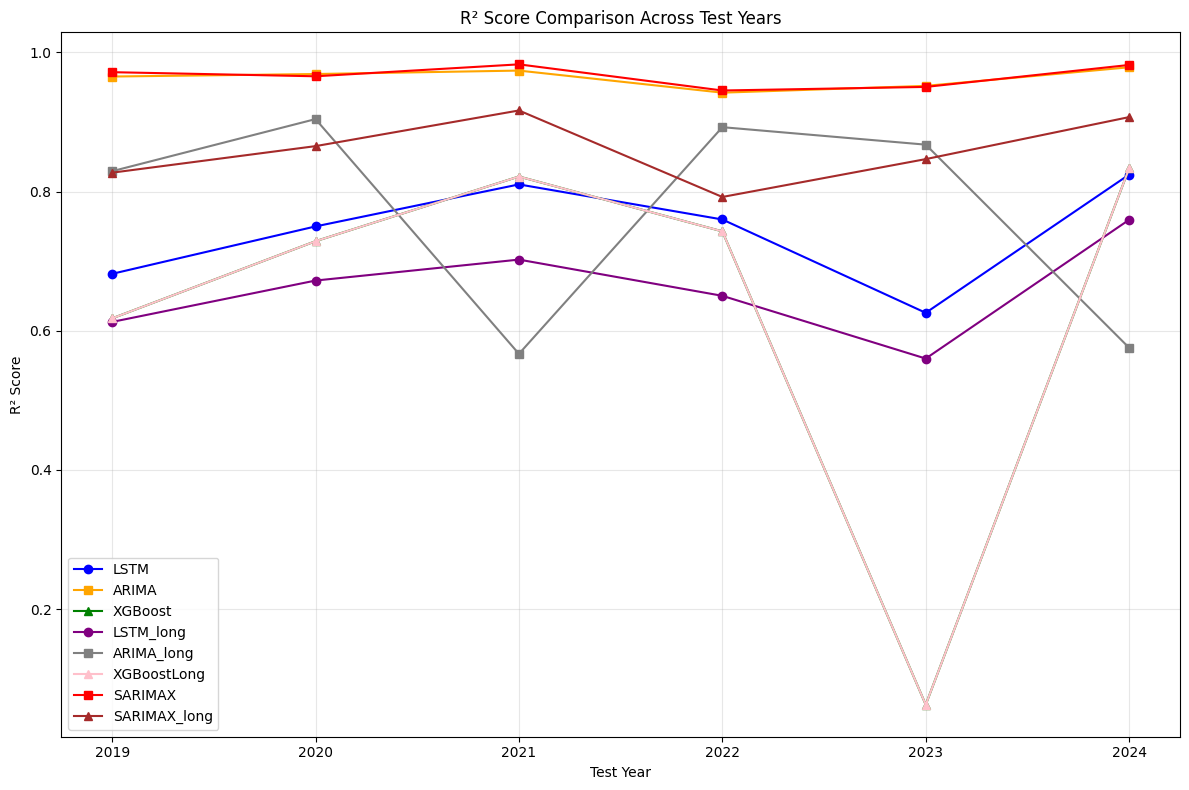

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results for all three models
df_lstm_long = pd.read_csv('/content/lstm_rolling_results_long.csv')
df_arima_long = pd.read_csv('/content/arima_direct_t10_metrics.csv')
df_xgboost_long = pd.read_csv('/content/xgboost_rolling_results_long.csv')
df_lstm = pd.read_csv('/content/lstm_rolling_results.csv')
df_arima = pd.read_csv('/content/arima_daily_rolling_metrics.csv')
df_xgboost = pd.read_csv('/content/xgboost_rolling_results.csv')
df_sarimax= pd.read_csv('/content/sarimax_rolling_results.csv')
df_sarimax_long= pd.read_csv('/content/sarimax_rolling_results_10_day.csv')


# Extract the R² score and test years from each model
lstm_r2 = df_lstm['R2']
arima_r2 = df_arima['R2']
xgboost_r2 = df_xgboost_long['R2']
arima_r2_long = df_arima_long['R2']
xgboost_r2_long = df_xgboost_long['R2']
sarimax_r2 = df_sarimax['R2']
sarimax_r2_long = df_sarimax_long['R2']
lstm_r2_long = df_lstm_long['R2']
# Create a list of test years for each model

# Define the test years (assuming the years are consistent across all models)
test_years = [2019, 2020, 2021, 2022, 2023, 2024]

# Plot the R² scores for all models
plt.figure(figsize=(12, 8))

plt.plot(test_years, lstm_r2, marker='o', label='LSTM', color='blue')
plt.plot(test_years, arima_r2, marker='s', label='ARIMA', color='orange')
plt.plot(test_years, xgboost_r2, marker='^', label='XGBoost', color='green')
plt.plot(test_years, lstm_r2_long, marker='o', label='LSTM_long', color='purple')
plt.plot(test_years, arima_r2_long, marker='s', label='ARIMA_long', color='grey')
plt.plot(test_years, xgboost_r2_long, marker='^', label='XGBoostLong', color='pink')
plt.plot(test_years, sarimax_r2, marker='s', label='SARIMAX', color='red')
plt.plot(test_years, sarimax_r2_long, marker='^', label='SARIMAX_long', color='brown')

# Adding title and labels
plt.title('R² Score Comparison Across Test Years')
plt.xlabel('Test Year')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True, alpha=0.3)

# Save the plot
plt.tight_layout()
plt.savefig('r2_comparison_across_models.png')
plt.show()

# reasoning for r^2
# best model selection(why so)
# variable importance in determing the exrate

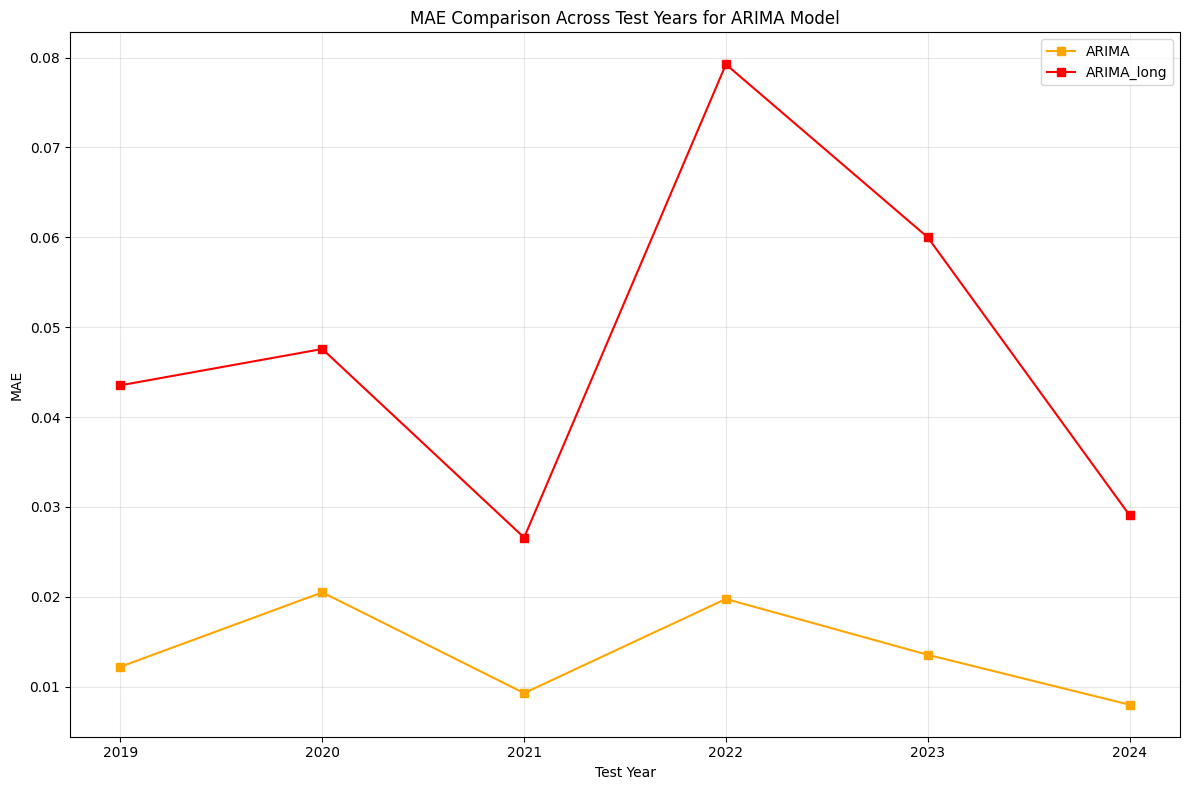

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results for all three models

df_arima_long = pd.read_csv('/content/arima_direct_t10_metrics.csv')

df_arima = pd.read_csv('/content/arima_daily_rolling_metrics.csv')

# Extract the R² score and test years from each model

arima_r2 = df_arima['MAE']

arima_r2_long = df_arima_long['MAE']


# Define the test years (assuming the years are consistent across all models)
test_years = [2019, 2020, 2021, 2022, 2023, 2024]

# Plot the R² scores for all models
plt.figure(figsize=(12, 8))


plt.plot(test_years, arima_r2, marker='s', label='ARIMA', color='orange')

plt.plot(test_years, arima_r2_long, marker='s', label='ARIMA_long', color='red')


# Adding title and labels
plt.title('MAE Comparison Across Test Years for ARIMA Model')
plt.xlabel('Test Year')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Save the plot
plt.tight_layout()
plt.savefig('r2_comparison_across_ARIMA_models.png')
plt.show()

# reasoning for r^2
# best model selection(why so)
# variable importance in determing the exrate

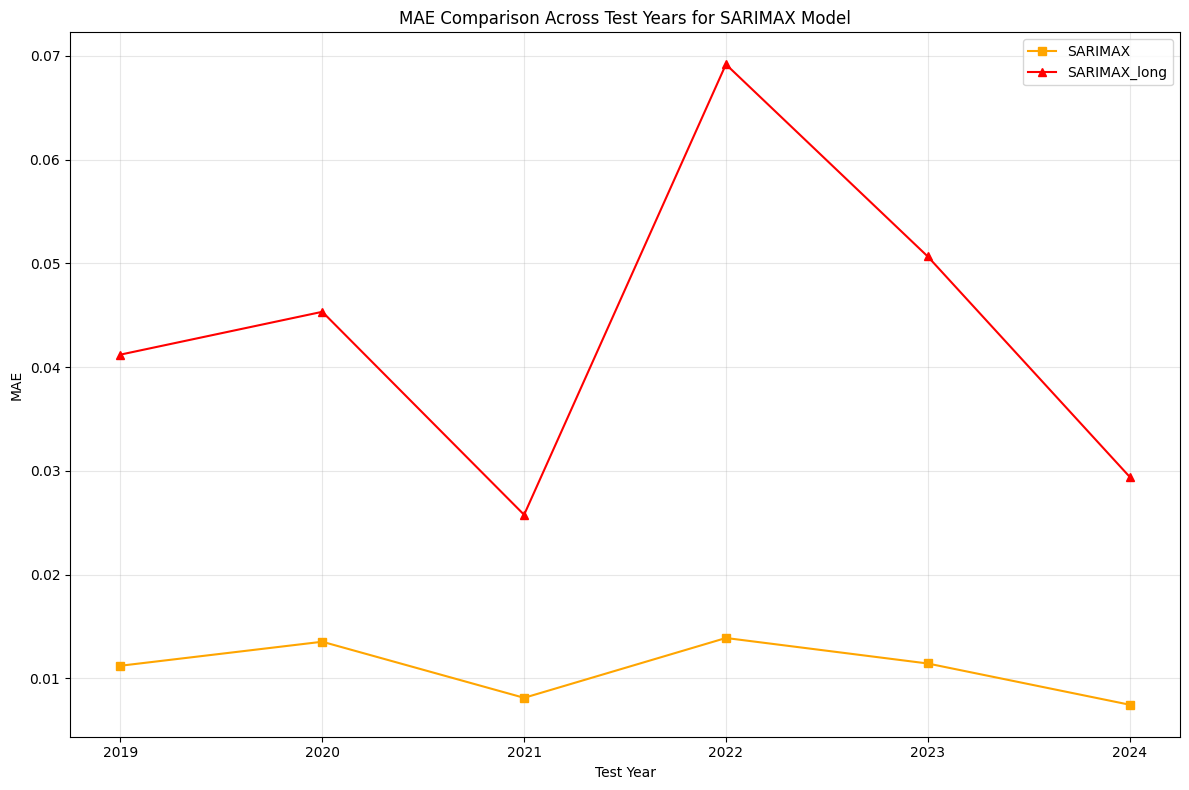

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results for all three models

df_sarimax= pd.read_csv('/content/sarimax_rolling_results.csv')
df_sarimax_long= pd.read_csv('/content/sarimax_rolling_results_10_day.csv')


# Extract the R² score and test years from each model
sarimax_r2 = df_sarimax['MAE']
sarimax_r2_long = df_sarimax_long['MAE']

# Create a list of test years for each model

# Define the test years (assuming the years are consistent across all models)
test_years = [2019, 2020, 2021, 2022, 2023, 2024]

# Plot the R² scores for all models
plt.figure(figsize=(12, 8))



plt.plot(test_years, sarimax_r2, marker='s', label='SARIMAX', color='orange')
plt.plot(test_years, sarimax_r2_long, marker='^', label='SARIMAX_long', color='red')

# Adding title and labels
plt.title('MAE Comparison Across Test Years for SARIMAX Model')
plt.xlabel('Test Year')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Save the plot
plt.tight_layout()
plt.savefig('MAE_comparison_across_SARIMAX.png')
plt.show()

# reasoning for r^2
# best model selection(why so)
# variable importance in determing the exrate

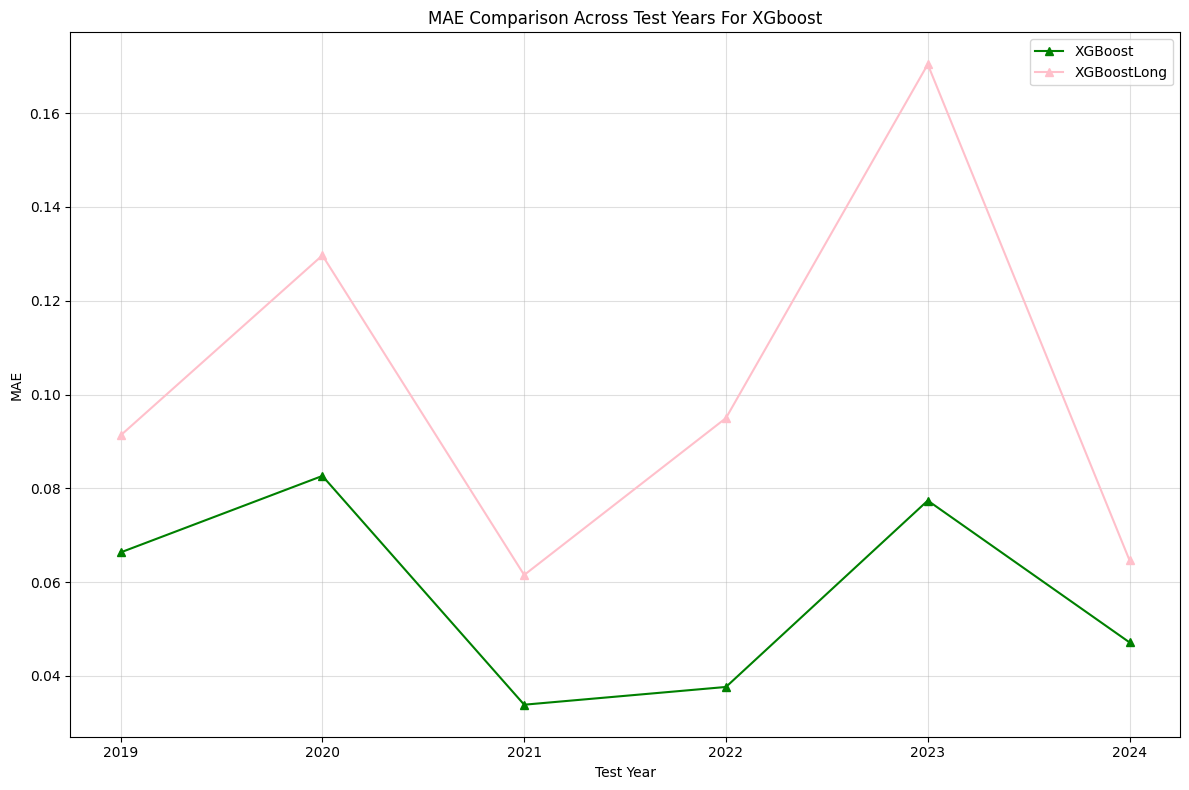

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results for all three models

df_xgboost_long = pd.read_csv('/content/xgboost_rolling_results_long.csv')
df_xgboost = pd.read_csv('/content/xgboost_rolling_results.csv')



# Extract the R² score and test years from each model

xgboost_r2 = df_xgboost['MAE']
xgboost_r2_long = df_xgboost_long['MAE']

# Create a list of test years for each model

# Define the test years (assuming the years are consistent across all models)
test_years = [2019, 2020, 2021, 2022, 2023, 2024]

# Plot the R² scores for all models
plt.figure(figsize=(12, 8))


plt.plot(test_years, xgboost_r2, marker='^', label='XGBoost', color='green')

plt.plot(test_years, xgboost_r2_long, marker='^', label='XGBoostLong', color='pink')

# Adding title and labels
plt.title('MAE Comparison Across Test Years For XGboost')
plt.xlabel('Test Year')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.4)

# Save the plot
plt.tight_layout()
plt.savefig('r2_comparison_across_models.png')
plt.show()

# reasoning for r^2
# best model selection(why so)
# variable importance in determing the exrate

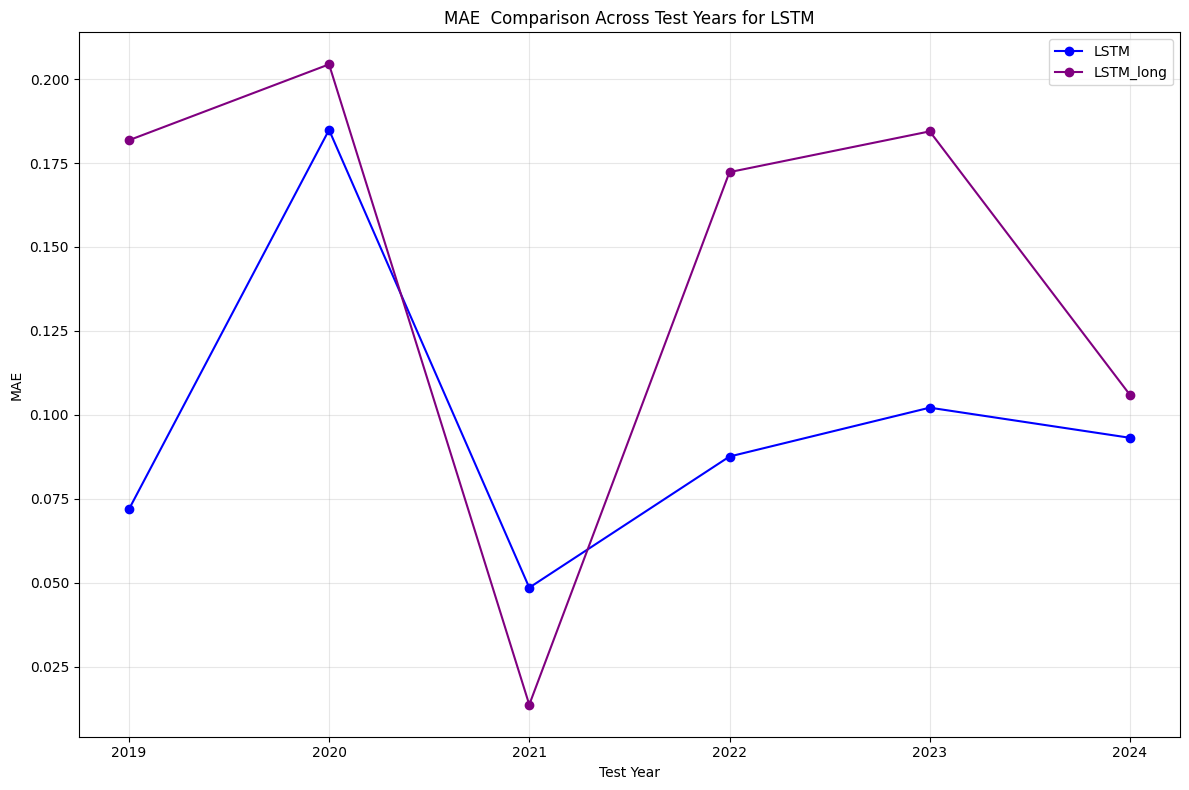

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results for all three models
df_lstm_long = pd.read_csv('/content/lstm_rolling_results_long.csv')
df_lstm = pd.read_csv('/content/lstm_rolling_results.csv')




# Extract the R² score and test years from each model
lstm_r2 = df_lstm['MAE']

lstm_r2_long = df_lstm_long['MAE']
# Create a list of test years for each model

# Define the test years (assuming the years are consistent across all models)
test_years = [2019, 2020, 2021, 2022, 2023, 2024]

# Plot the R² scores for all models
plt.figure(figsize=(12, 8))

plt.plot(test_years, lstm_r2, marker='o', label='LSTM', color='blue')

plt.plot(test_years, lstm_r2_long, marker='o', label='LSTM_long', color='purple')



# Adding title and labels
plt.title('MAE  Comparison Across Test Years for LSTM')
plt.xlabel('Test Year')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Save the plot
plt.tight_layout()
plt.savefig('MAE_comparison_across_models.png')
plt.show()

# reasoning for r^2
# best model selection(why so)
# variable importance in determing the exrate

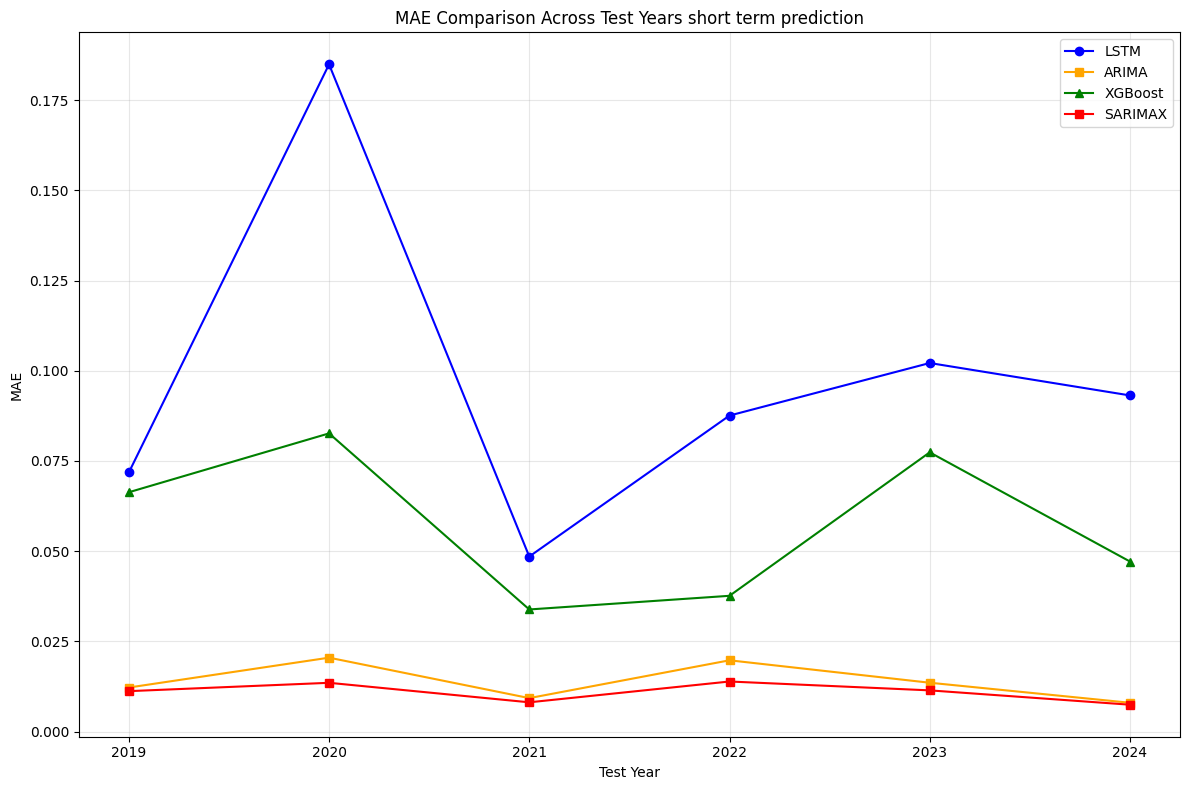

In [11]:
import pandas as pd
import matplotlib.pyplot as plt



df_lstm = pd.read_csv('/content/lstm_rolling_results.csv')
df_arima = pd.read_csv('/content/arima_daily_rolling_metrics.csv')
df_xgboost = pd.read_csv('/content/xgboost_rolling_results.csv')
df_sarimax= pd.read_csv('/content/sarimax_rolling_results.csv')



# Extract the R² score and test years from each model
lstm_r2 = df_lstm['MAE']
arima_r2 = df_arima['MAE']
xgboost_r2 = df_xgboost['MAE']
sarimax_r2 = df_sarimax['MAE']


# Define the test years (assuming the years are consistent across all models)
test_years = [2019, 2020, 2021, 2022, 2023, 2024]

# Plot the R² scores for all models
plt.figure(figsize=(12, 8))

plt.plot(test_years, lstm_r2, marker='o', label='LSTM', color='blue')
plt.plot(test_years, arima_r2, marker='s', label='ARIMA', color='orange')
plt.plot(test_years, xgboost_r2, marker='^', label='XGBoost', color='green')
# plt.plot(test_years, lstm_r2_long, marker='o', label='LSTM_long', color='purple')
# plt.plot(test_years, arima_r2_long, marker='s', label='ARIMA_long', color='grey')
# plt.plot(test_years, xgboost_r2_long, marker='^', label='XGBoostLong', color='pink')
plt.plot(test_years, sarimax_r2, marker='s', label='SARIMAX', color='red')
# plt.plot(test_years, sarimax_r2_long, marker='^', label='SARIMAX_long', color='brown')

# Adding title and labels
plt.title('MAE Comparison Across Test Years short term prediction')
plt.xlabel('Test Year')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Save the plot
plt.tight_layout()
plt.savefig('mae_comparison_across_models.png')
plt.show()

# reasoning for r^2
# best model selection(why so)
# variable importance in determing the exrate

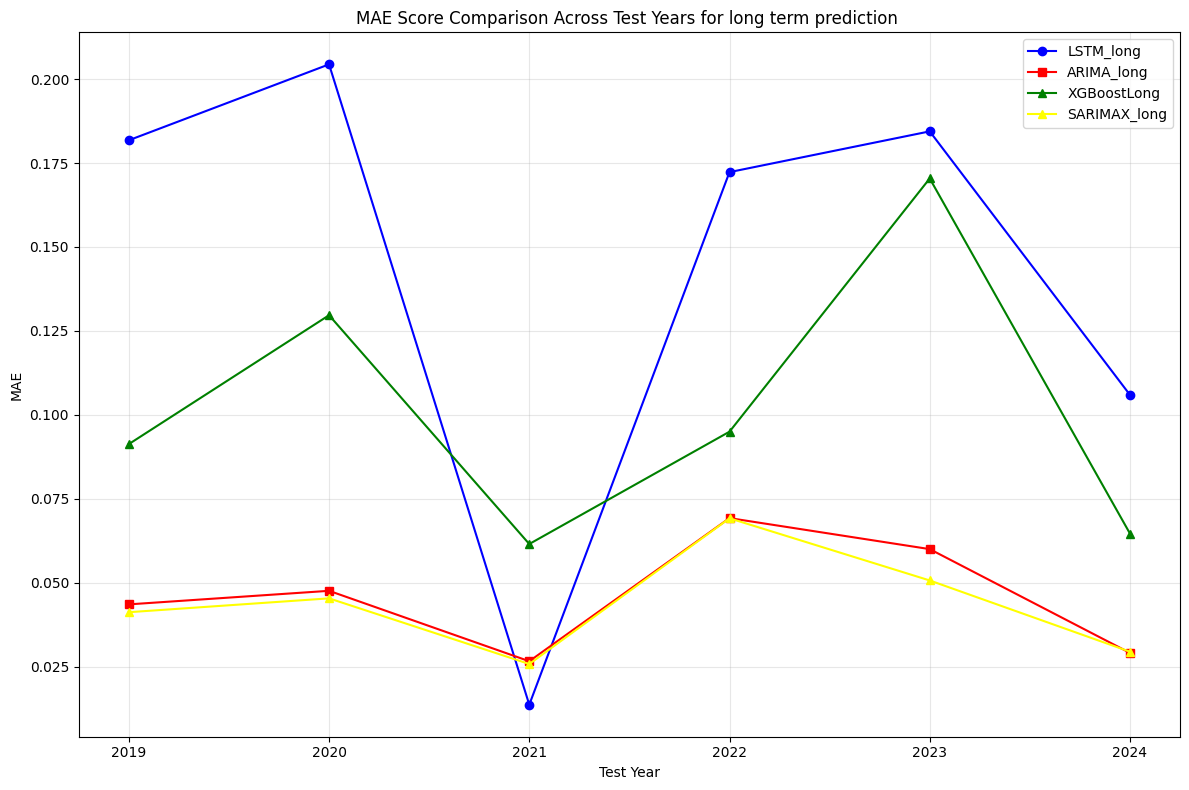

In [14]:
import pandas as pd
import matplotlib.pyplot as plt


df_lstm_long = pd.read_csv('/content/lstm_rolling_results_long.csv')
df_arima_long = pd.read_csv('/content/arima_direct_t10_metrics.csv')
df_xgboost_long = pd.read_csv('/content/xgboost_rolling_results_long.csv')
df_sarimax_long= pd.read_csv('/content/sarimax_rolling_results_10_day.csv')


# Extract the R² score and test years from each model
lstm_r2_long = df_lstm_long['MAE']
arima_r2_long = df_arima_long['MAE']
xgboost_r2_long = df_xgboost_long['MAE']
sarimax_r2_long = df_sarimax_long['MAE']

# Create a list of test years for each model

# Define the test years (assuming the years are consistent across all models)
test_years = [2019, 2020, 2021, 2022, 2023, 2024]

# Plot the R² scores for all models
plt.figure(figsize=(12, 8))


plt.plot(test_years, lstm_r2_long, marker='o', label='LSTM_long', color='blue')
plt.plot(test_years, arima_r2_long, marker='s', label='ARIMA_long', color='red')
plt.plot(test_years, xgboost_r2_long, marker='^', label='XGBoostLong', color='green')

plt.plot(test_years, sarimax_r2_long, marker='^', label='SARIMAX_long', color='yellow')

# Adding title and labels
plt.title('MAE Score Comparison Across Test Years for long term prediction ')
plt.xlabel('Test Year')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Save the plot
plt.tight_layout()
plt.savefig('MAE_comparison_across_models.png')
plt.show()

# reasoning for r^2
# best model selection(why so)
# variable importance in determing the exrate

**DM TEST**

In [20]:
import pandas as pd
import numpy as np
from scipy import stats
import os

# === Diebold-Mariano Test Function ===
def dm_test(e1, e2, h=1, crit="MSE"):
    e1, e2 = np.array(e1), np.array(e2)
    if crit == "MSE":
        d = (e1**2) - (e2**2)
    elif crit == "MAE":
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("crit must be either 'MSE' or 'MAE'")
    d_mean = np.mean(d)
    d_var = np.var(d, ddof=1)
    dm_stat = d_mean / np.sqrt((d_var / len(d)))
    p_value = 2 * stats.norm.cdf(-abs(dm_stat))
    return dm_stat, p_value

# === Years to Compare ===
years = [2019, 2020, 2021, 2022, 2023, 2024]

# === Results Container ===
dm_results = []

for year in years:
    try:
        # === Load All Prediction Files ===
        arima = pd.read_csv(f"/content/arima_daily_{year}.csv")
        arima_long = pd.read_csv(f"/content/arima_t10_{year}.csv")
        xgb = pd.read_csv(f"/content/xgboost_predictions_{year}.csv")
        xgb_long = pd.read_csv(f"/content/xgboost_predictions_{year}_long.csv")
        lstm = pd.read_csv(f"/content/lstm_predictions_{year}.csv")
        lstm_long = pd.read_csv(f"/content/lstm_predictions_{year}_long.csv")
        sarimax = pd.read_csv(f"/content/sarimax_predictions_{year} (1).csv")  # Add SARIMAX
        sarimax_long = pd.read_csv(f"/content/sarimax_predictions_{year}_long (1).csv")  # Add SARIMAX Long

        # === Merge on Date ===
        df = arima[['Date', 'Actual']].merge(
            arima[['Date', 'Predicted']].rename(columns={'Predicted': 'ARIMA'}), on='Date'
        ).merge(
            xgb[['Date', 'Predicted']].rename(columns={'Predicted': 'XGB'}), on='Date'
        ).merge(
            lstm[['Date', 'Predicted']].rename(columns={'Predicted': 'LSTM'}), on='Date'
        ).merge(
            sarimax[['Date', 'Predicted']].rename(columns={'Predicted': 'SARIMAX'}), on='Date'
        ).merge(
            arima_long[['Date', 'Predicted']].rename(columns={'Predicted': 'ARIMA_LONG'}), on='Date'
        ).merge(
            xgb_long[['Date', 'Predicted']].rename(columns={'Predicted': 'XGB_LONG'}), on='Date'
        ).merge(
            lstm_long[['Date', 'Predicted']].rename(columns={'Predicted': 'LSTM_LONG'}), on='Date'
        ).merge(
            sarimax_long[['Date', 'Predicted']].rename(columns={'Predicted': 'SARIMAX_LONG'}), on='Date'
        )

        # === Drop NaNs to Avoid DM Errors ===
        df = df.dropna(subset=['Actual', 'ARIMA', 'XGB', 'LSTM', 'SARIMAX', 'ARIMA_LONG', 'XGB_LONG', 'LSTM_LONG', 'SARIMAX_LONG'])

        # === Calculate Forecast Errors ===
        e_arima = df['Actual'] - df['ARIMA']
        e_xgb = df['Actual'] - df['XGB']
        e_lstm = df['Actual'] - df['LSTM']
        e_sarimax = df['Actual'] - df['SARIMAX']
        e_arima_long = df['Actual'] - df['ARIMA_LONG']
        e_xgb_long = df['Actual'] - df['XGB_LONG']
        e_lstm_long = df['Actual'] - df['LSTM_LONG']
        e_sarimax_long = df['Actual'] - df['SARIMAX_LONG']

        # === DM Tests Without Long ===
        dm1, p1 = dm_test(e_arima, e_xgb)  # ARIMA vs XGB
        dm2, p2 = dm_test(e_arima, e_lstm)  # ARIMA vs LSTM
        dm3, p3 = dm_test(e_arima, e_sarimax)  # ARIMA vs SARIMAX
        dm4, p4 = dm_test(e_xgb, e_lstm)   # XGB vs LSTM
        dm5, p5 = dm_test(e_xgb, e_sarimax)  # XGB vs SARIMAX
        dm6, p6 = dm_test(e_lstm, e_sarimax) # LSTM vs SARIMAX

        # === DM Tests With Long ===
        dm7, p7 = dm_test(e_arima_long, e_xgb_long)  # ARIMA_LONG vs XGB_LONG
        dm8, p8 = dm_test(e_arima_long, e_lstm_long)  # ARIMA_LONG vs LSTM_LONG
        dm9, p9 = dm_test(e_arima_long, e_sarimax_long)  # ARIMA_LONG vs SARIMAX_LONG
        dm10, p10 = dm_test(e_xgb_long, e_lstm_long)  # XGB_LONG vs LSTM_LONG
        dm11, p11 = dm_test(e_xgb_long, e_sarimax_long)  # XGB_LONG vs SARIMAX_LONG
        dm12, p12 = dm_test(e_lstm_long, e_sarimax_long)  # LSTM_LONG vs SARIMAX_LONG

        # === Save to Results List ===
        dm_results.append({
            'Year': year,
            # Without Long
            'ARIMA vs XGB - DM Stat': dm1, 'p-value 1': p1,
            'ARIMA vs LSTM - DM Stat': dm2, 'p-value 2': p2,
            'ARIMA vs SARIMAX - DM Stat': dm3, 'p-value 3': p3,
            'XGB vs LSTM - DM Stat': dm4, 'p-value 4': p4,
            'XGB vs SARIMAX - DM Stat': dm5, 'p-value 5': p5,
            'LSTM vs SARIMAX - DM Stat': dm6, 'p-value 6': p6,
            # With Long
            'ARIMA_LONG vs XGB_LONG - DM Stat': dm7, 'p-value 7': p7,
            'ARIMA_LONG vs LSTM_LONG - DM Stat': dm8, 'p-value 8': p8,
            'ARIMA_LONG vs SARIMAX_LONG - DM Stat': dm9, 'p-value 9': p9,
            'XGB_LONG vs LSTM_LONG - DM Stat': dm10, 'p-value 10': p10,
            'XGB_LONG vs SARIMAX_LONG - DM Stat': dm11, 'p-value 11': p11,
            'LSTM_LONG vs SARIMAX_LONG - DM Stat': dm12, 'p-value 12': p12
        })

    except Exception as e:
        print(f"❌ Error in year {year}: {e}")

# === Convert to DataFrame and Save ===
# === Convert to DataFrame and Save ===
dm_df = pd.DataFrame(dm_results)

# === Save the results to a CSV file ===
output_path = "/content/dm_test_results.csv"
dm_df.to_csv(output_path, index=False)

# === Print Result ===
print("✅ DM Test Results have been saved to CSV:")
print(dm_df)

# Return the file path for the user to download
output_path


✅ DM Test Results have been saved to CSV:
   Year  ARIMA vs XGB - DM Stat     p-value 1  ARIMA vs LSTM - DM Stat  \
0  2019               -9.170214  4.720823e-20               -23.333080   
1  2020               -8.903540  5.409308e-19               -14.284484   
2  2021               -3.963405  7.388827e-05               -16.026240   
3  2022               -7.401282  1.348755e-13               -12.681330   
4  2023              -10.499402  8.692869e-26               -19.039647   
5  2024              -14.490749  1.386224e-47               -17.894644   

       p-value 2  ARIMA vs SARIMAX - DM Stat     p-value 3  \
0  2.047070e-120                    4.127531  3.666797e-05   
1   2.734285e-46                   -0.670344  5.026383e-01   
2   8.380176e-58                    4.142155  3.440573e-05   
3   7.504759e-37                    5.745445  9.167962e-09   
4   8.006489e-81                    5.101449  3.370623e-07   
5   1.298245e-71                    3.685048  2.286592e-04   

   X

'/content/dm_test_results.csv'